<a href="https://colab.research.google.com/github/CarlosSotero/NFL_Stats_Players/blob/main/NFL_Moderna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas nescessárias**

In [91]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## **Download dos datasets**

In [92]:
# Download latest version
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nfl-stats-1999-2022' dataset.
Path to dataset files: /kaggle/input/nfl-stats-1999-2022


In [93]:
# Mostra os arquivos que vieram no caminho do kagglehub
print(os.listdir(path))


['yearly_player_stats_defense.csv', 'yearly_player_stats_offense.csv', 'yearly_team_stats_offense.csv', 'weekly_player_stats_offense.csv', 'yearly_team_stats_defense.csv', 'weekly_player_stats_defense.csv', 'weekly_team_stats_defense.csv', 'weekly_team_stats_offense.csv']


In [94]:
# Carregar os datasets anuais por jogador (ofensivo e defensivo)
offense_path = path + "/yearly_player_stats_offense.csv"
defense_path = path + "/yearly_player_stats_defense.csv"
df_offense = pd.read_csv(offense_path)
df_defense = pd.read_csv(defense_path)

# Colunas do df de ataque selecionadas
offense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'years_exp',
    'pass_attempts', 'complete_pass', 'passing_yards', 'pass_touchdown', 'interception',
    'passer_rating', 'comp_pct', 'ypa',
    'rush_attempts', 'rushing_yards', 'rush_touchdown', 'fumble', 'fumble_lost', 'ypc',
    'targets', 'receptions', 'receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'yptarget', 'ypr',
    'total_yards', 'total_tds', 'fantasy_points_ppr', 'fantasy_points_standard',
    'season_ypg', 'season_yptouch', 'season_average_ppr_ppg', 'offense_snaps', 'offense_pct'
]

# DF de Ataque com as colunas selecionadas
df_offense_reduzido = df_offense[offense_cols]
print("Shape do DF Ofensivo reduzido:", df_offense_reduzido.shape)


# Colunas do df de defesa selecionadas
defense_cols = [
    'player_id', 'player_name', 'position', 'team', 'season', 'age', 'games_played_season',
    'height', 'weight', 'college', 'draft_year', 'draft_round', 'draft_pick', 'seasons_played',
    'solo_tackle', 'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit',
    'interception', 'fumble_forced', 'safety', 'def_touchdown',
    'defense_snaps', 'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'
]

# DF de Defesa com as colunas selecionadas
df_defense_reduzido = df_defense[defense_cols]
print("Shape do DF Defensivo reduzido:", df_defense_reduzido.shape)


Shape do DF Ofensivo reduzido: (7133, 44)
Shape do DF Defensivo reduzido: (16148, 27)


##**LImpeza dos Dados**

In [95]:
print("🟦 OFENSIVO -----------------------")
print(df_offense_reduzido.info())
print("\n")
print("🟥 DEFENSIVO ----------------------")
print(df_defense_reduzido.info())

🟦 OFENSIVO -----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7133 entries, 0 to 7132
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_id                7133 non-null   object 
 1   player_name              7133 non-null   object 
 2   position                 7133 non-null   object 
 3   team                     7133 non-null   object 
 4   season                   7133 non-null   int64  
 5   age                      7133 non-null   float64
 6   games_played_season      7133 non-null   int64  
 7   height                   7133 non-null   float64
 8   weight                   7133 non-null   float64
 9   college                  7133 non-null   object 
 10  draft_year               7133 non-null   float64
 11  draft_round              6043 non-null   float64
 12  draft_pick               6043 non-null   float64
 13  years_exp                7115 non-null   fl

### **Ataque**

In [96]:
# Criando uma cópia do DF de ataque
df_ataque_limpo = df_offense_reduzido.copy()

# Loop para preencher os valores ausentes
for col in df_ataque_limpo.columns:
  if df_ataque_limpo[col].dtype == 'object':
    df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_ataque_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_ataque_limpo.columns:
  df_ataque_limpo['college'] = df_ataque_limpo['college'].replace(['0', 0], 'Desconhecido')


# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'years_exp', 'age']:
  if col in df_ataque_limpo.columns:
    df_ataque_limpo[col] = df_ataque_limpo[col].astype(int, errors='ignore')

print("Ataque limpo:", df_ataque_limpo.shape)
print("Nulos restantes:", df_ataque_limpo.isnull().sum().sum())

Ataque limpo: (7133, 44)
Nulos restantes: 0


/tmp/ipython-input-207400779.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ataque_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-207400779.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [97]:
print('Amostra de 10 jogadores aleatórios do ataque:')
df_ataque_limpo.sample(10)

Amostra de 10 jogadores aleatórios do ataque:


,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,ypr,total_yards,total_tds,fantasy_points_ppr,fantasy_points_standard,season_ypg,season_yptouch,season_average_ppr_ppg,offense_snaps,offense_pct
1277,00-0031299,Jordan Matthews,TE,PHI,2014,22,16,75.0,236.0,Vanderbilt,...,13.01,872.0,16.0,200.20,133.20,3.41,13.01,12.51,765.0,0.651064
100,00-0024369,Jeff King,TE,ARI,2012,29,11,75.0,260.0,Virginia Tech,...,7.59,129.0,0.0,25.90,8.90,1.07,7.57,2.35,332.0,0.444444
5545,00-0034160,Michael Dickson,P,SEA,2022,26,2,74.0,208.0,Texas,...,0.00,-18.0,0.0,-4.80,-4.80,-4.50,-9.00,-2.40,0.0,0.000000
3741,00-0033293,Aaron Jones,RB,GB,2019,24,16,70.0,208.0,UTEP,...,9.67,1558.0,22.0,312.80,263.80,6.09,5.47,19.55,663.0,0.615599
784,00-0030216,Josh Hill,TE,NO,2013,23,6,77.0,250.0,Idaho State,...,7.33,36.0,2.0,15.60,9.60,1.00,5.13,2.60,126.0,0.315789
3468,00-0027966,Mark Ingram,RB,BAL,2019,29,15,69.0,215.0,Alabama,...,9.50,1265.0,20.0,236.50,210.50,5.62,5.50,15.77,504.0,0.484615
4605,00-0036020,Salvon Ahmed,RB,MIA,2020,21,6,71.0,197.0,Washington,...,5.55,380.0,3.0,67.00,56.00,10.56,4.42,11.17,205.0,0.509950
6910,00-0037258,Dameon Pierce,RB,HOU,2024,24,9,70.0,215.0,Florida,...,1.00,295.0,2.0,43.50,41.50,3.64,7.02,4.83,104.0,0.178082
1783,00-0022942,Philip Rivers,QB,LAC,2016,34,16,77.0,228.0,North Carolina State,...,0.00,4421.0,33.0,319.94,319.94,17.27,7.74,20.00,1060.0,0.995305
6269,00-0036322,Justin Jefferson,WR,MIN,2023,24,7,73.0,195.0,LSU,...,15.51,810.0,8.0,155.00,102.00,16.53,15.01,22.14,418.0,0.928889


###**Defesa**

In [98]:
# Criando uma cópia do DF de ataque
df_defesa_limpo = df_defense_reduzido.copy()

# Remove linhas que estão sem o nome e a posição dos jogadores
df_defesa_limpo = df_defesa_limpo.dropna(subset=['player_name', 'position'])

# Loop para preencher os valores ausentes
for col in df_defesa_limpo.columns:
  if df_defesa_limpo[col].dtype == 'object':
    df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
  else:
    df_defesa_limpo[col].fillna(0, inplace=True)

# Substituindo o 0 por 'Desconhecido' na coluna 'college'
if 'college' in df_defesa_limpo.columns:
  df_defesa_limpo['college'] = df_defesa_limpo['college'].replace(['0', 0], 'Desconhecido')

# Alterando o tipo das colunas de float para int
for col in ['draft_year', 'draft_round', 'draft_pick', 'age']:
    if col in df_defesa_limpo.columns:
        df_defesa_limpo[col] = df_defesa_limpo[col].astype(int, errors='ignore')

print("Defensivo limpo:", df_defesa_limpo.shape)
print("Nulos restantes:", df_defesa_limpo.isnull().sum().sum())

Defensivo limpo: (12332, 27)
Nulos restantes: 0


/tmp/ipython-input-2341386716.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_defesa_limpo[col].fillna('Desconhecido', inplace=True)
/tmp/ipython-input-2341386716.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [99]:
print('Amostra de 10 jogadores aleatórios da defesa:')
df_defesa_limpo.sample(10)

Amostra de 10 jogadores aleatórios da defesa:


,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,sack,qb_hit,interception,fumble_forced,safety,def_touchdown,defense_snaps,defense_pct,fantasy_points_ppr,fantasy_points_standard
5482,00-0030420,David Amerson,CB,LV,2016,25,16.0,73.0,205.0,North Carolina State,...,0.0,3.0,5.0,0,0.0,0.0,0.0,0.000000,0,0
7013,00-0032763,Austin Johnson,DT,TEN,2017,23,16.0,76.0,314.0,Penn State,...,3.0,3.0,0.0,0,0.0,0.0,358.0,0.330258,0,0
8485,00-0034754,Oren Burks,LB,GB,2018,23,8.0,75.0,233.0,Vanderbilt,...,0.0,0.0,0.0,0,0.0,0.0,112.0,0.214559,0,0
8498,00-0034778,Carlton Davis,CB,TB,2018,22,13.0,73.0,206.0,Auburn,...,0.0,1.0,0.0,2,0.0,0.0,718.0,0.847698,0,0
12900,00-0034413,Foyesade Oluokun,LB,JAX,2022,27,19.0,74.0,230.0,Yale,...,8.0,24.0,0.0,6,0.0,0.0,1283.0,0.986164,0,0
2649,00-0026150,Jerod Mayo,MLB,NE,2014,0,6.0,0.0,0.0,Desconhecido,...,4.0,6.0,0.0,0,0.0,0.0,334.0,0.863049,0,0
961,00-0028038,Da'Norris Searcy,S,BUF,2012,24,12.0,71.0,205.0,North Carolina,...,0.0,0.0,0.0,5,0.0,0.0,259.0,0.320545,0,0
7897,00-0031615,Christian Ringo,DT,CIN,2018,26,5.0,73.0,300.0,Louisiana-Lafayette,...,7.0,8.0,0.0,0,0.0,0.0,144.0,0.463023,0,0
14539,00-0037083,Kingsley Enagbare,DE,GB,2023,23,17.0,76.0,258.0,South Carolina,...,6.0,11.0,0.0,3,0.0,0.0,471.0,0.412434,0,0
6458,00-0029594,Sean Spence,ILB,PIT,2017,0,5.0,0.0,0.0,Desconhecido,...,4.0,6.0,0.0,0,0.0,0.0,218.0,0.717105,0,0


### **Análises dos dados**

In [100]:
# Verificando a quantidade por de valores unicos por temporada
print(df_ataque_limpo['season'].value_counts().sort_index())
print(df_defesa_limpo['season'].value_counts().sort_index())


season
2012    411
2013    421
2014    480
2015    455
2016    515
2017    545
2018    593
2019    618
2020    650
2021    638
2022    626
2023    604
2024    577
Name: count, dtype: int64
season
2012     865
2013     877
2014     912
2015     912
2016     925
2017     927
2018     942
2019     968
2020     995
2021    1050
2022     984
2023     983
2024     992
Name: count, dtype: int64


In [101]:
# Conferindo as posições do Ataque e Defesa
print('Posições ataque:', df_ataque_limpo['position'].unique())

print('Posições defesa:', df_defesa_limpo['position'].unique())

Posições ataque: ['QB' 'WR' 'TE' 'P' 'RB' 'FS' 'FB' 'CB' 'LS' 'ILB' 'DT' 'DE' 'NT' 'SS' 'K'
 'T' 'OLB' 'MLB']
Posições defesa: ['ILB' 'CB' 'FS' 'OLB' 'DE' 'MLB' 'NT' 'DT' 'SS' 'LB' 'S' 'WR' 'RB' 'TE'
 'DB' 'FB' 'T' 'C' 'G']


In [102]:
# Diagnóstico: quantos jogadores estão fora de posição
ataque_incorreto = df_ataque_limpo.query("offense_snaps == 0")
defesa_incorreta = df_defesa_limpo.query("defense_snaps == 0")

print("Jogadores de defesa no dataset de ataque:")
print(ataque_incorreto[['player_name', 'position', 'offense_snaps']])

print("\nJogadores de ataque no dataset de defesa:")
print(defesa_incorreta[['player_name', 'position', 'defense_snaps']])

# Verifique o tamanho
n_ataque = len(df_ataque_limpo)
n_defesa = len(df_defesa_limpo)
pct_ataque_incorreto = len(ataque_incorreto) / n_ataque * 100
pct_defesa_incorreta = len(defesa_incorreta) / n_defesa * 100

print(f"\n{pct_ataque_incorreto:.2f}% dos registros de ataque são jogadores de defesa.")
print(f"{pct_defesa_incorreta:.2f}% dos registros de defesa são jogadores de ataque.")


Jogadores de defesa no dataset de ataque:
               player_name position  offense_snaps
14           Shane Lechler        P            0.0
68         Dustin Colquitt        P            0.0
104               Sam Koch        P            0.0
105               Sam Koch        P            0.0
120            Eric Weddle       FS            0.0
...                    ...      ...            ...
6886         Divine Deablo      MLB            0.0
6963           Dane Belton       SS            0.0
6972  Carrington Valentine       CB            0.0
7103           Jaden Hicks       SS            0.0
7104       Kamren Kinchens       FS            0.0

[179 rows x 3 columns]

Jogadores de ataque no dataset de defesa:
                player_name position  defense_snaps
16             Takeo Spikes      ILB            0.0
38          Richard Seymour       DT            0.0
40             Andre Carter       DE            0.0
69           Quentin Jammer       CB            0.0
72           Quinti

In [103]:
# Contabilizando os jogadores de ataque que estão no df de defesa
defesa_incorreta['position'].value_counts()

,count
position,
WR,308
CB,234
DE,167
DT,142
LB,131
S,104
RB,94
TE,58
OLB,40


In [104]:
# Eliminando os jogadores com 0 snaps dos dfs
df_ataque_limpo = df_ataque_limpo.query("offense_snaps > 0")
df_defesa_limpo = df_defesa_limpo.query("defense_snaps > 0")


###**Feature Engineering**

####**Ataque**

In [105]:
#  Total de Touchdowns
df_ataque_limpo['total_touchdown'] = df_ataque_limpo['pass_touchdown'] + df_ataque_limpo['rush_touchdown']


# Jardas por tentativa de passe (protege contra divisão por zero)
df_ataque_limpo['yards_per_pass_attempt'] = np.where(
    df_ataque_limpo['pass_attempts'] > 0,
    df_ataque_limpo['passing_yards'] / df_ataque_limpo['pass_attempts'],
    0
)

# Jardas por tentativa de corrida
df_ataque_limpo['yards_per_carry'] = np.where(
    df_ataque_limpo['rush_attempts'] > 0,
    df_ataque_limpo['rushing_yards'] / df_ataque_limpo['rush_attempts'],
    0
)

# Jardas por recepção
df_ataque_limpo['yards_per_reception'] = np.where(
    df_ataque_limpo['receptions'] > 0,
    df_ataque_limpo['receiving_yards'] / df_ataque_limpo['receptions'],
    0
)

# Taxa de recepção
df_ataque_limpo['catch_rate'] = np.where(
    df_ataque_limpo['targets'] > 0,
    df_ataque_limpo['receptions'] / df_ataque_limpo['targets'],
    0
)

# Total de "touches" (corridas + recepções)
df_ataque_limpo['touches'] = df_ataque_limpo['rush_attempts'] + df_ataque_limpo['receptions']

# Jardas por toque
df_ataque_limpo['yards_per_touch'] = np.where(
    df_ataque_limpo['touches'] > 0,
    df_ataque_limpo['total_yards'] / df_ataque_limpo['touches'],
    0
)


In [106]:
# 5 jogadores aleatorios de ataque
df_ataque_limpo.sample(5)

,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,season_average_ppr_ppg,offense_snaps,offense_pct,total_touchdown,yards_per_pass_attempt,yards_per_carry,yards_per_reception,catch_rate,touches,yards_per_touch
5353,00-0029604,Kirk Cousins,QB,MIN,2022,34,17,75.0,205.0,Michigan State,...,20.03,1114.0,0.954584,31.0,7.228935,3.129032,0.000000,0.000000,31.0,149.806452
3187,00-0032980,Marcus Johnson,WR,IND,2018,24,4,73.0,207.0,Texas,...,5.50,90.0,0.291262,1.0,0.000000,-2.000000,17.000000,0.750000,7.0,14.285714
4090,00-0028002,Randall Cobb,WR,HOU,2020,30,10,70.0,192.0,Kentucky,...,10.01,369.0,0.604918,3.0,0.000000,0.000000,11.605263,0.791667,38.0,11.605263
6848,00-0036628,John Bates,TE,WAS,2024,26,2,78.0,259.0,Boise State,...,3.05,56.0,0.368421,0.0,0.000000,0.000000,10.333333,0.750000,3.0,10.333333
112,00-0025396,Ted Ginn,WR,SF,2012,27,3,71.0,180.0,Ohio State,...,0.93,30.0,0.145631,0.0,0.000000,7.000000,0.500000,1.000000,3.0,2.666667


###**Defesa**

In [107]:
# Colunas no df de defesa
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard'],
      dtype='object')

In [108]:
# Tackle totais
df_defesa_limpo['tackles_total'] = df_defesa_limpo['solo_tackle'] + df_defesa_limpo['assist_tackle']

# Taxa de sacks por snap
df_defesa_limpo['sack_rate'] = df_defesa_limpo['sack'] / df_defesa_limpo['defense_snaps']

# Taxa de interceptações por snap
df_defesa_limpo['int_rate'] = df_defesa_limpo['interception'] / df_defesa_limpo['defense_snaps']

# Taxa de fumbles forçados por snap
df_defesa_limpo['ff_rate'] = df_defesa_limpo['fumble_forced'] / df_defesa_limpo['defense_snaps']

# Tackles por jogo
df_defesa_limpo['tackles_per_game'] = df_defesa_limpo['tackles_total'] / df_defesa_limpo['games_played_season']

# Jogadas impactantes (sack + INT + fumble_forced + safety + defensive TD)
df_defesa_limpo['impact_plays'] = (
    df_defesa_limpo['sack'] +
    df_defesa_limpo['interception'] +
    df_defesa_limpo['fumble_forced'] +
    df_defesa_limpo['safety'] +
    df_defesa_limpo['def_touchdown']
)


In [109]:
# 5 jogadores aleatorios de defesa
df_defesa_limpo.sample(5)

,player_id,player_name,position,team,season,age,games_played_season,height,weight,college,...,defense_snaps,defense_pct,fantasy_points_ppr,fantasy_points_standard,tackles_total,sack_rate,int_rate,ff_rate,tackles_per_game,impact_plays
12244,00-0036553,Carlos Basham,DE,BUF,2021,24,10.0,75.0,274.0,Wake Forest,...,245.0,0.375191,0,0,37.0,0.061224,0.000000,0.00000,3.700000,15.0
8395,00-0034341,Matthew Thomas,LB,PIT,2018,23,1.0,75.0,232.0,Florida State,...,4.0,0.059701,0,0,1.0,0.000000,0.000000,0.00000,1.000000,0.0
4217,00-0029040,Damon Harrison,DT,NYJ,2015,27,14.0,75.0,355.0,William Penn,...,507.0,0.553493,0,0,80.0,0.009862,0.000000,0.00789,5.714286,9.0
8102,00-0032793,Blake Countess,S,LA,2018,25,3.0,70.0,191.0,Auburn,...,46.0,0.264368,0,0,4.0,0.000000,0.043478,0.00000,1.333333,2.0
7868,00-0031548,Kevin Johnson,CB,HOU,2018,26,1.0,72.0,185.0,Wake Forest,...,65.0,0.866667,0,0,4.0,0.000000,0.000000,0.00000,4.000000,0.0


##**Análise Exploratória**

###**Ataque**

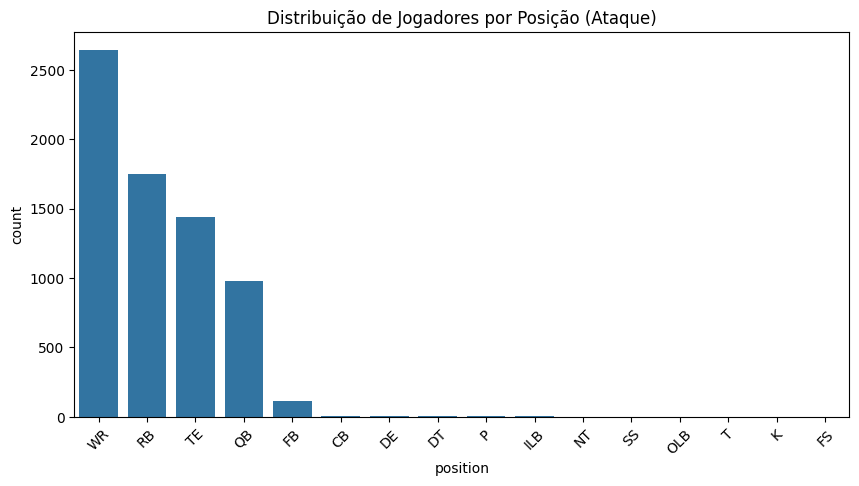

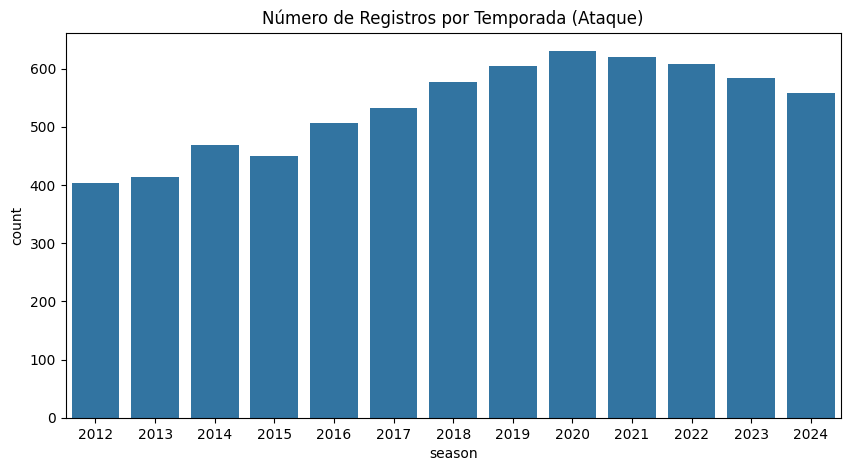

In [110]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='position', order=df_ataque_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Ataque)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_ataque_limpo, x='season')
plt.title('Número de Registros por Temporada (Ataque)')
plt.show()


In [111]:
# Estatísticas do ataque
df_ataque_limpo.describe()[['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr']]

,passing_yards,rushing_yards,receiving_yards,total_touchdown,fantasy_points_ppr
count,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000
mean,234.644953,102.130860,221.098504,3.616192,78.678392
std,842.062334,239.783109,306.600714,6.347103,89.907939
min,-7.000000,-31.000000,-15.000000,0.000000,-4.720000
25%,0.000000,0.000000,11.000000,0.000000,11.200000
50%,0.000000,2.000000,85.000000,1.000000,41.400000
75%,0.000000,61.000000,310.000000,4.000000,119.700000
max,5477.000000,2027.000000,1964.000000,56.000000,513.980000


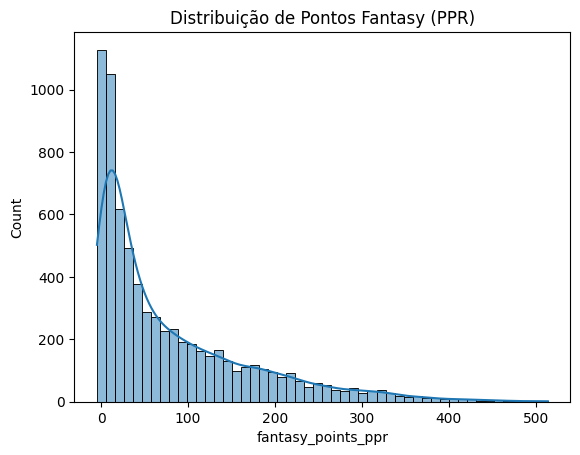

In [112]:
# Distribuição de Pontos do Fantasy
sns.histplot(df_ataque_limpo['fantasy_points_ppr'], bins=50, kde=True)
plt.title('Distribuição de Pontos Fantasy (PPR)')
plt.show()


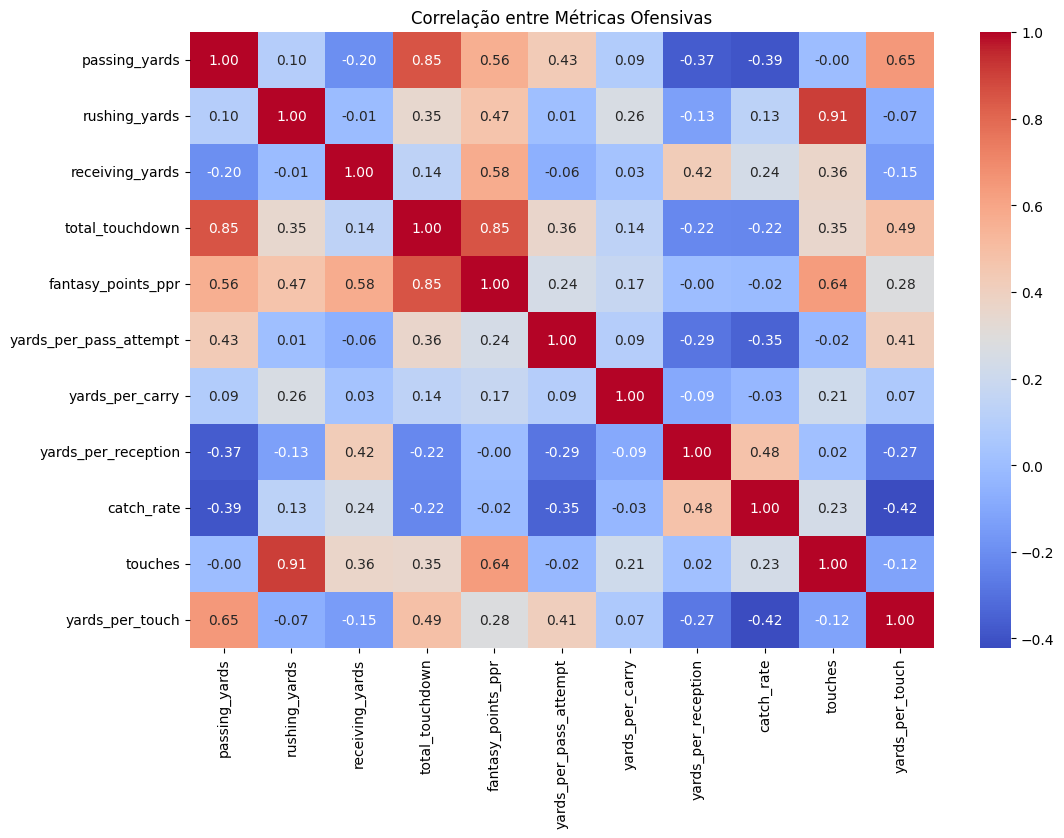

In [113]:
# Correlação entre variáveis
corr_cols = ['passing_yards', 'rushing_yards', 'receiving_yards', 'total_touchdown', 'fantasy_points_ppr', 'yards_per_pass_attempt',
             'yards_per_carry',  'yards_per_reception', 'catch_rate', 'touches', 'yards_per_touch']
plt.figure(figsize=(12, 8))
sns.heatmap(df_ataque_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Ofensivas')
plt.show()


#### **QBs**

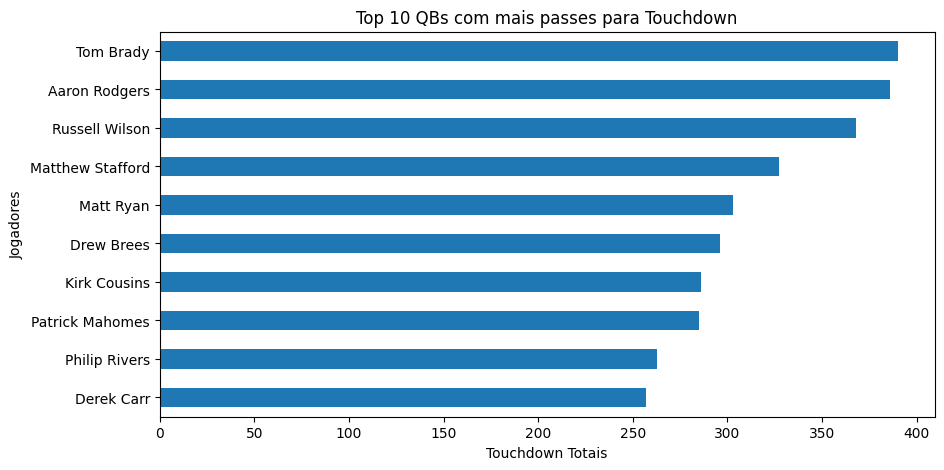

In [183]:
# Top QBs com mais passes para touchdown
qbs= df_ataque_limpo[df_ataque_limpo['position'] == 'QB']
top_qbs_touch = qbs.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown')
plt.ylabel('Jogadores')
plt.xlabel('Touchdown Totais')
plt.show()


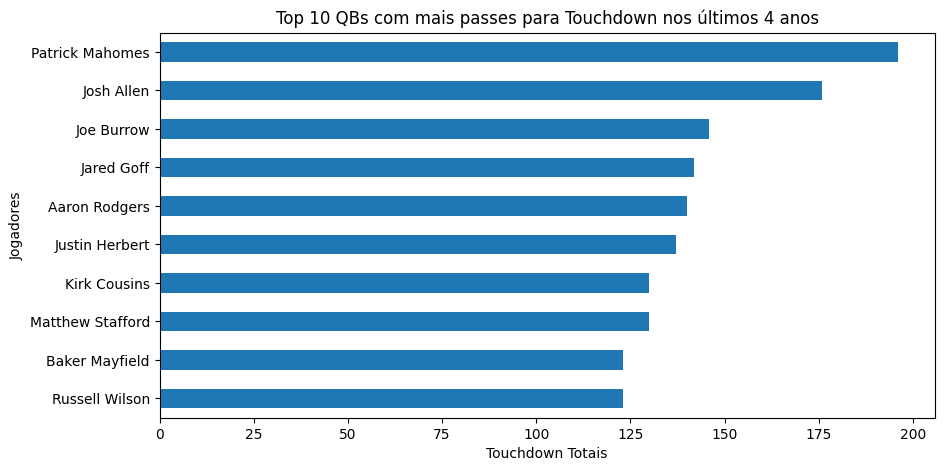

In [185]:
# Top QBs com mais passes para touchdown nos últimos 4 anos
qbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'QB') & (df_ataque_limpo['season'] >= 2020)]
top_qbs_touch_recente = qbs_recentes.groupby('player_name')['pass_touchdown'].sum().nlargest(10)
top_qbs_touch_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes para Touchdown nos últimos 4 anos')
plt.xlabel('Touchdown Totais')
plt.ylabel('Jogadores')
plt.show()

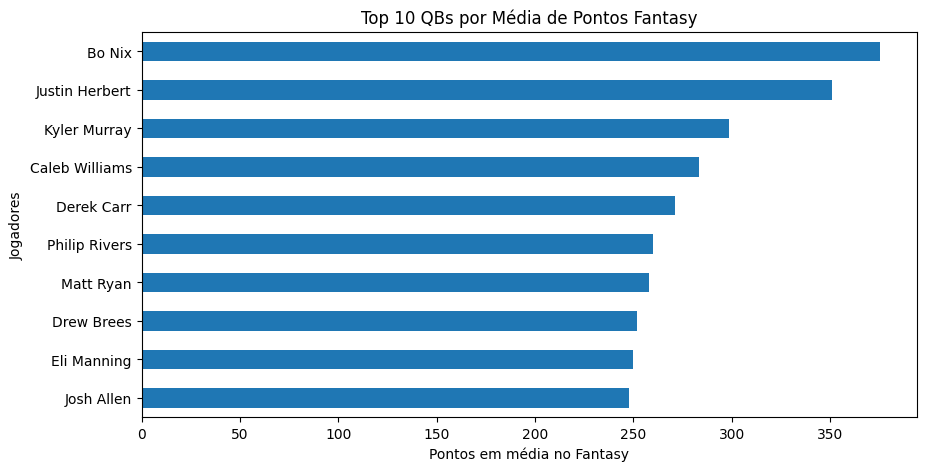

In [190]:
# Top QBs em média de pontos fantasy
top_qbs_fantasy = qbs.groupby('player_name')['fantasy_points_ppr'].mean().nlargest(10)
top_qbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Média de Pontos Fantasy')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()


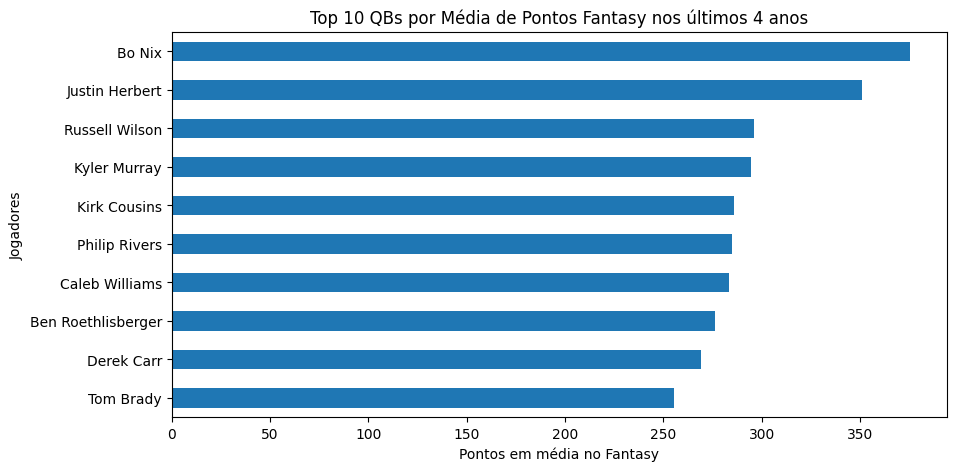

In [191]:
# Top QBs em média de pontos fantasy nos últimos quatros anos
top_qbs_fantasy_recentes = qbs_recentes.groupby('player_name')['fantasy_points_ppr'].mean().nlargest(10)
top_qbs_fantasy_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs por Média de Pontos Fantasy nos últimos 4 anos')
plt.xlabel('Pontos em média no Fantasy')
plt.ylabel('Jogadores')
plt.show()

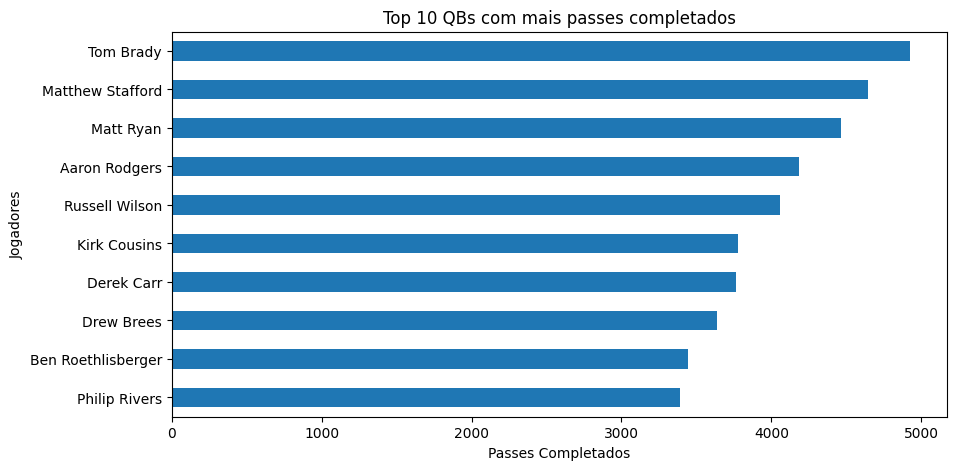

In [189]:
# Top QBs com mais passes completados
top_qbs_compl = qbs.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados')
plt.xlabel('Passes Completados')
plt.ylabel('Jogadores')
plt.show()

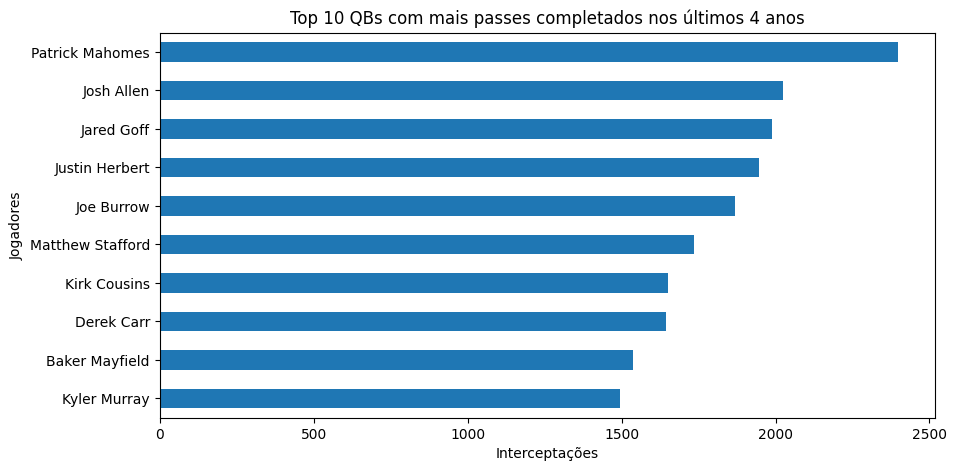

In [192]:
# Top QBs com mais passes completados os últimos 4 anos
top_qbs_compl_recentes = qbs_recentes.groupby('player_name')['complete_pass'].sum().nlargest(10)
top_qbs_compl_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais passes completados nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

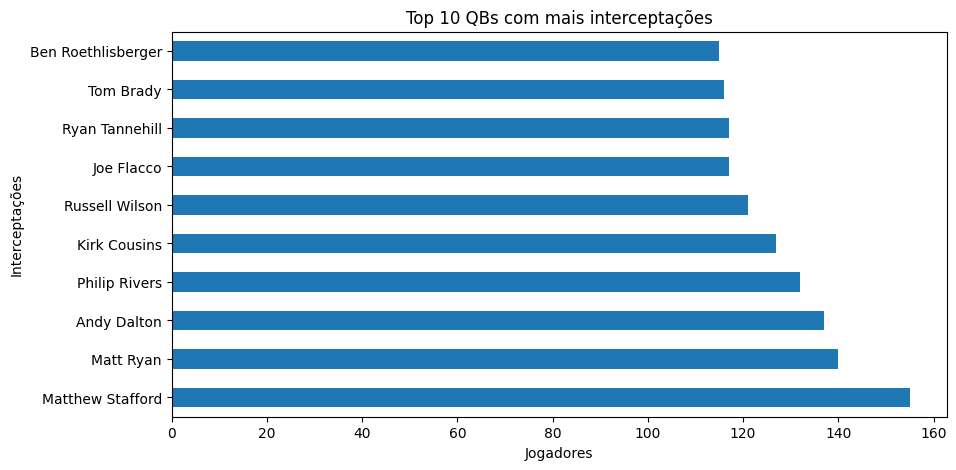

In [120]:
# Top QBs com mais interceptações
top_qbs_int = qbs.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

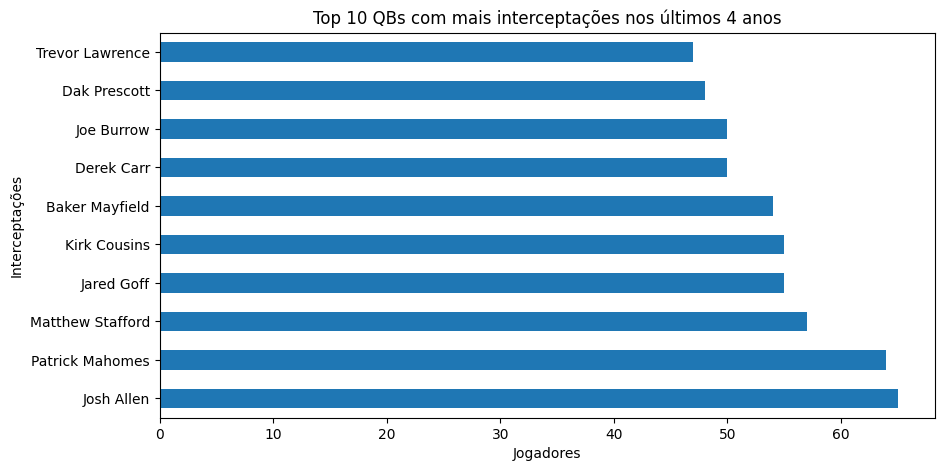

In [121]:
# Top QBs com mais interceptações nos últimos 4 anos
top_qbs_int = qbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_qbs_int.plot(kind='barh', figsize=(10,5), title='Top 10 QBs com mais interceptações nos últimos 4 anos')
plt.ylabel('Interceptações')
plt.xlabel('Jogadores')
plt.show()

####**WR**

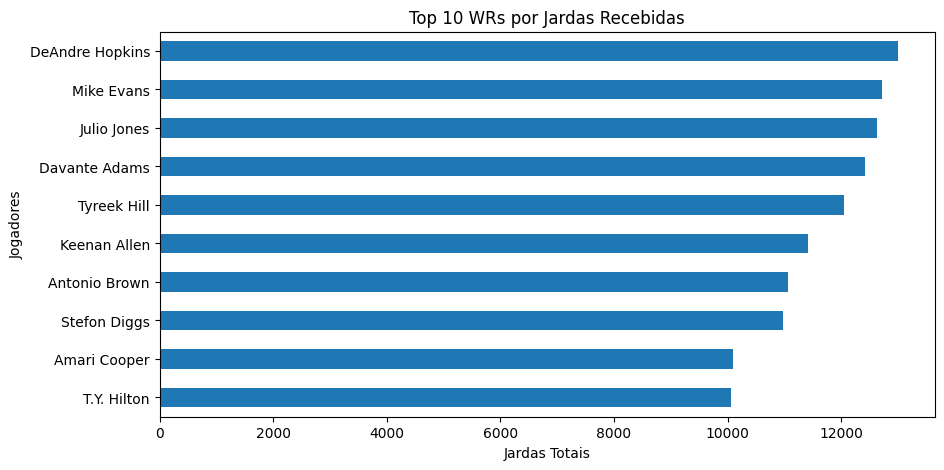

In [193]:
# Top WRs em jardas recebidas
wrs = df_ataque_limpo[df_ataque_limpo['position'] == 'WR']
top_wrs = wrs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


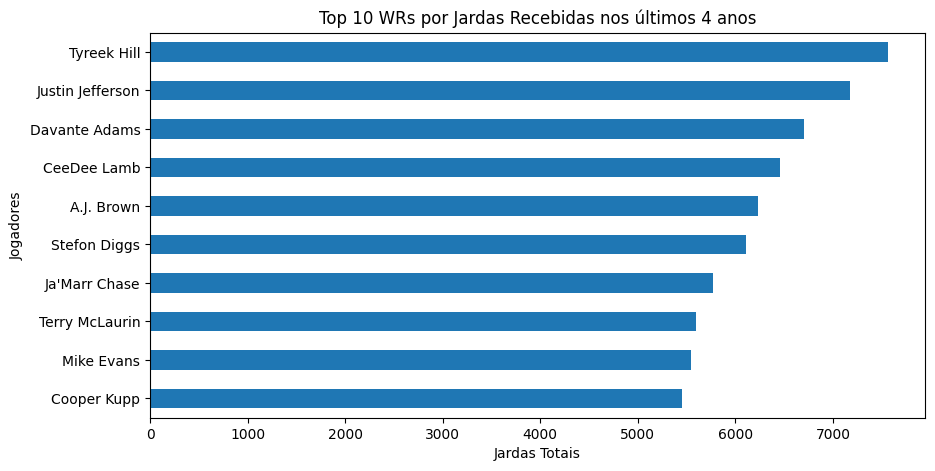

In [194]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'WR') & (df_ataque_limpo['season'] >= 2020)]
top_wrs_jardas_recentes = top_wrs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_wrs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


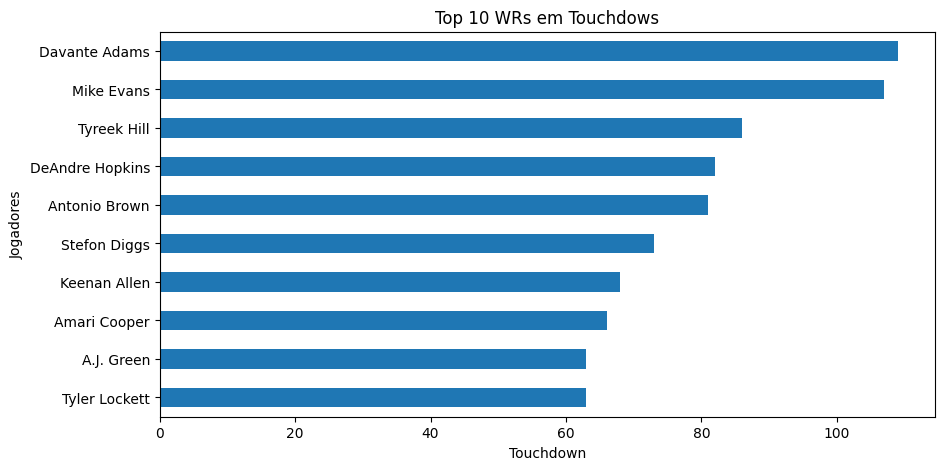

In [195]:
# Top WRs em Tochdowns
top_wrs_touch = wrs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

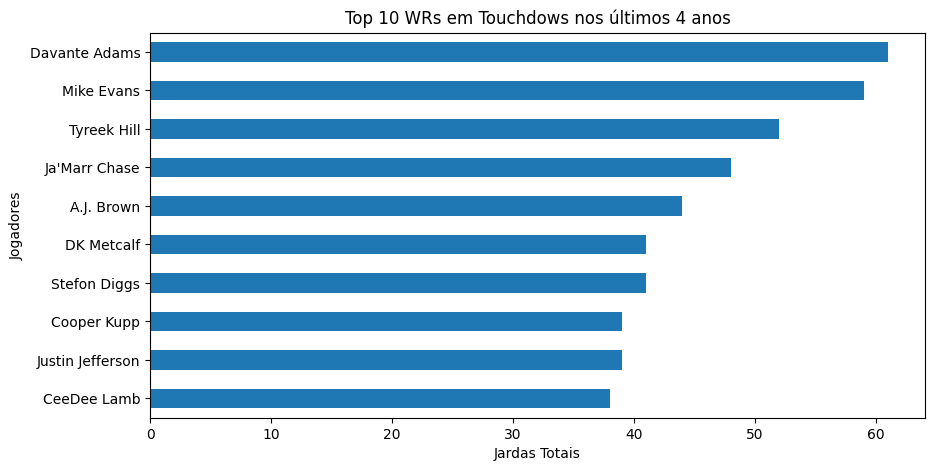

In [196]:
# Top WRs em jardas recebidas nos últimos 4 anos
top_wrs_touch_recentes = top_wrs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_wrs_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()


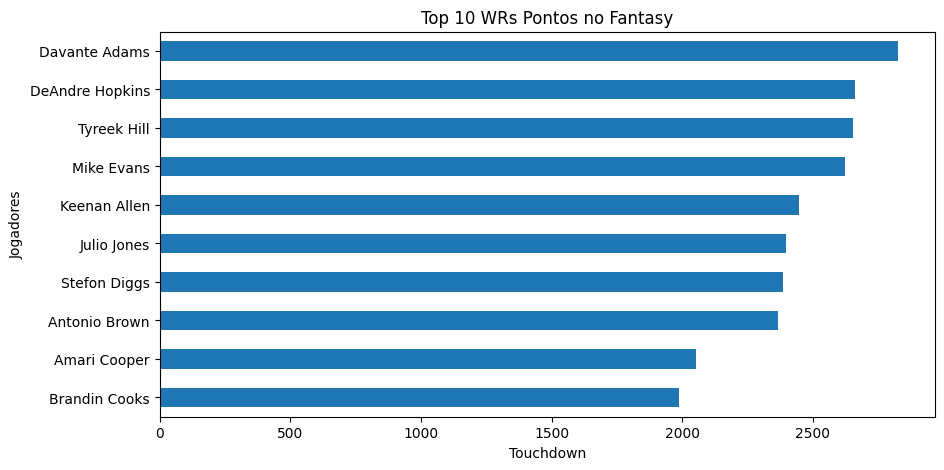

In [197]:
# Top WRs Pontos no Fantasy
top_wrs_fantasy = wrs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

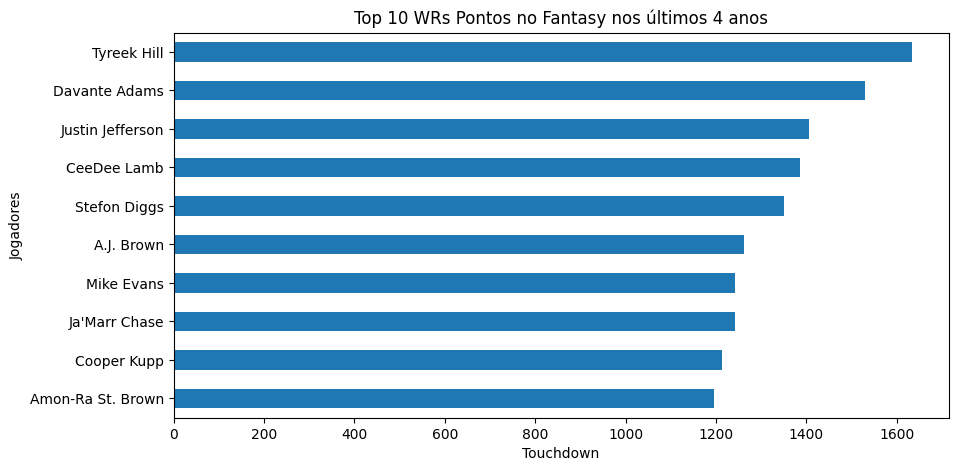

In [198]:
# Top WRs Pontos no Fantasy nos últimos 4 anos
top_wrs_fantasy_recente = top_wrs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_wrs_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

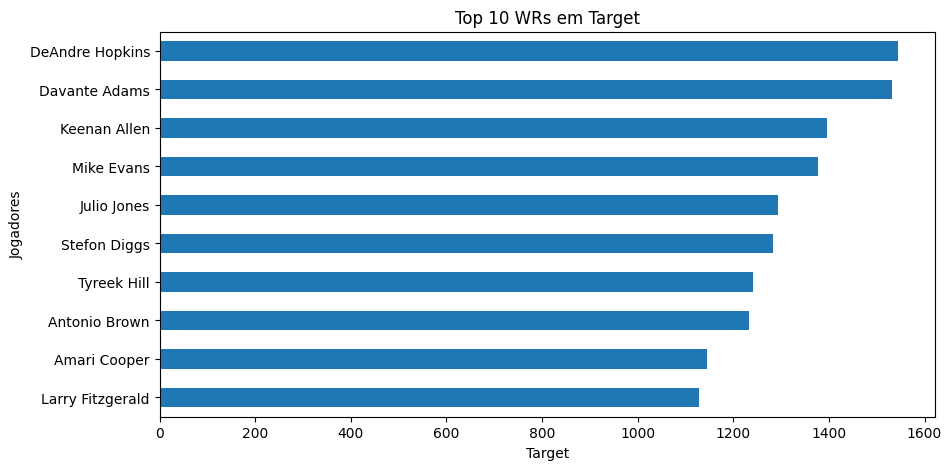

In [199]:
# Top WRs em Target
top_wrs_target = wrs.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


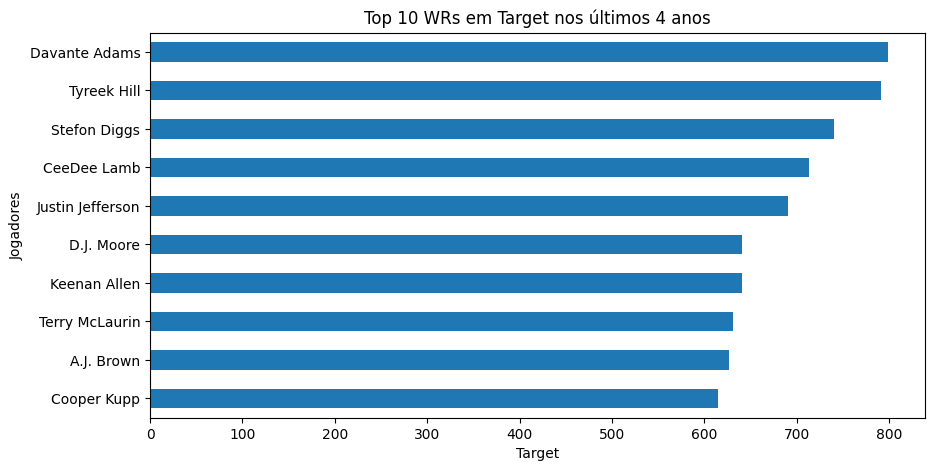

In [200]:
# Top WRs em Target nos últimos 4 anos
top_wrs_target_recentes = top_wrs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_wrs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()


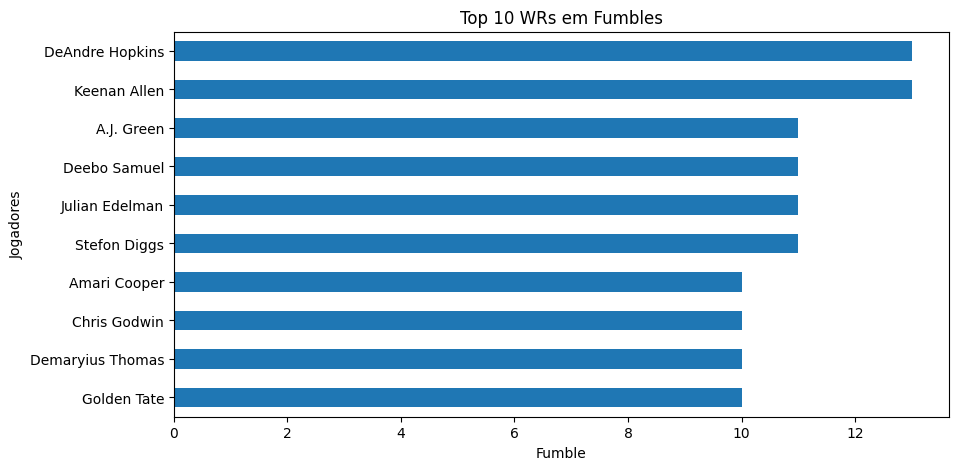

In [201]:
# Top WRs em Fumble
top_wrs_fumble = wrs.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

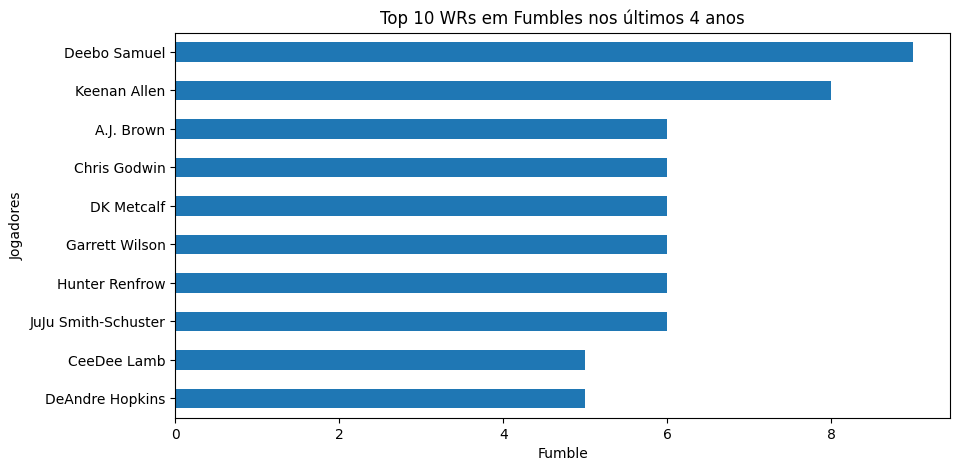

In [202]:
# Top WRs em Fumblee nos últimos 4 anos
top_wrs_fumble_recentes = top_wrs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_wrs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 WRs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**TE**

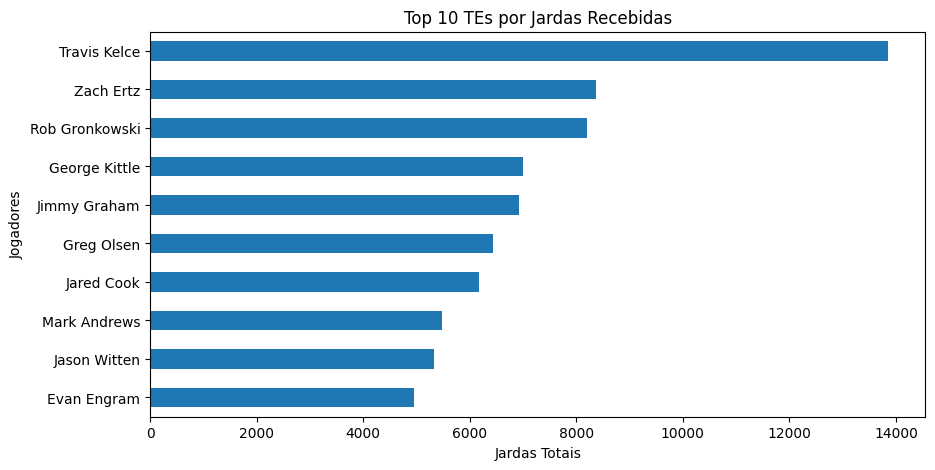

In [204]:
# Top TE em jardas recebidas
tes = df_ataque_limpo[df_ataque_limpo['position'] == 'TE']
top_tes = tes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

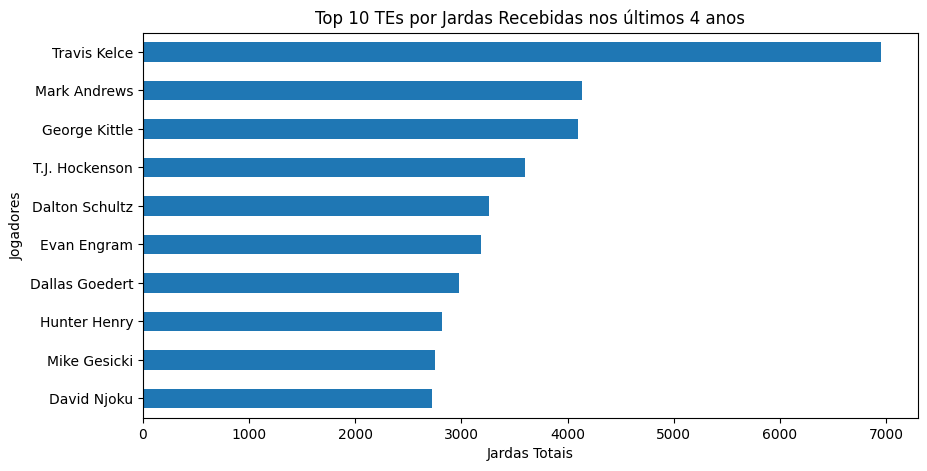

In [205]:
# Top tes em jardas recebidas nos últimos 4 anos
top_tes_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'TE') & (df_ataque_limpo['season'] >= 2020)]
top_tes_jardas_recentes = top_tes_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_tes_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

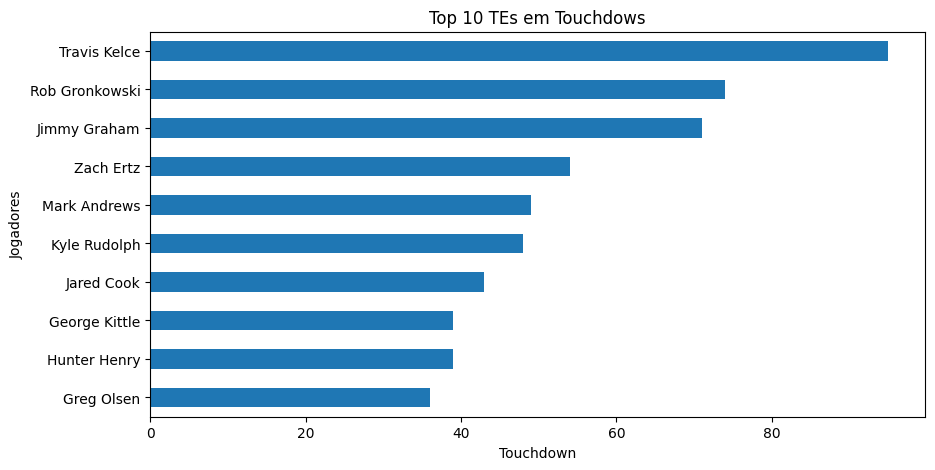

In [206]:
# Top TEs em Tochdowns
top_tes_touch = tes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

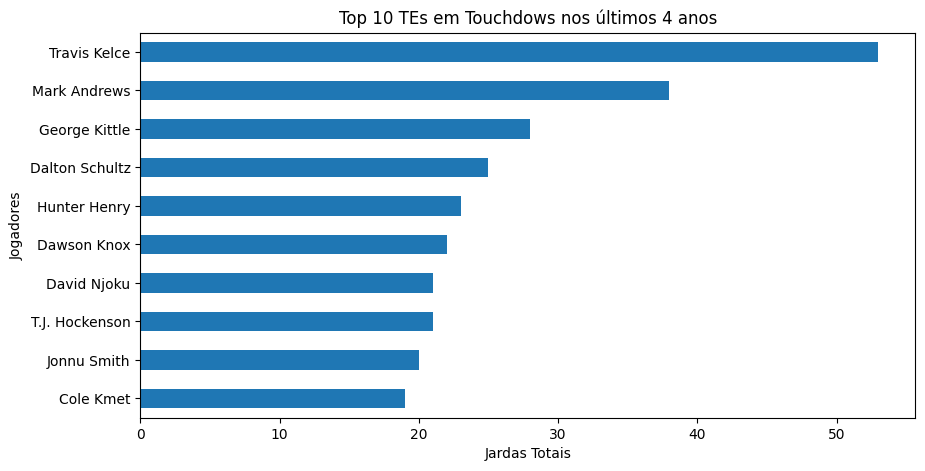

In [207]:
# Top TEs em jardas recebidas nos últimos 4 anos
top_tes_touch_recentes = top_tes_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_tes_touch_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Touchdows nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

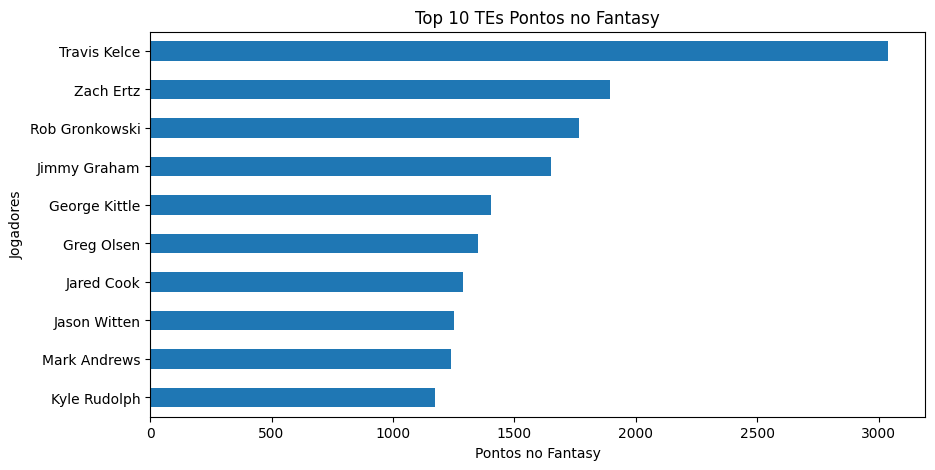

In [211]:
# Top TEs Pontos no Fantasy
top_tes_fantasy = tes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

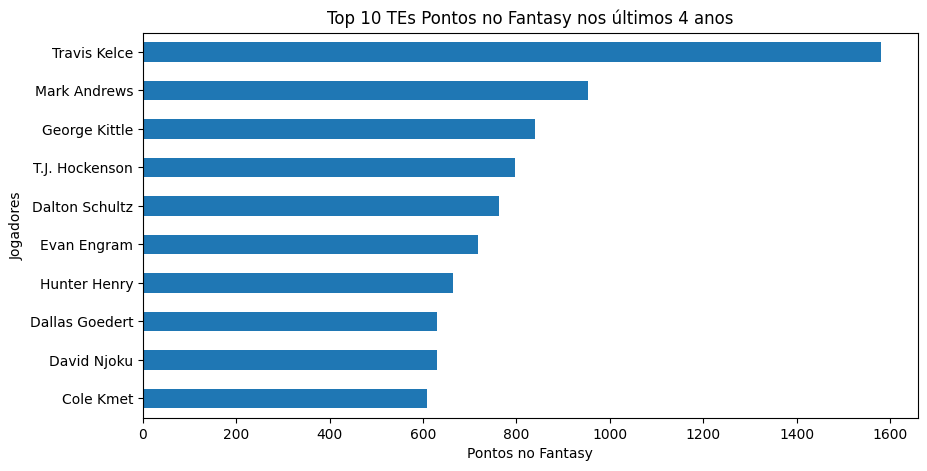

In [212]:
# Top TEs Pontos no Fantasy nos últimos 4 anos
top_tes_fantasy_recente = top_tes_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_tes_fantasy_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

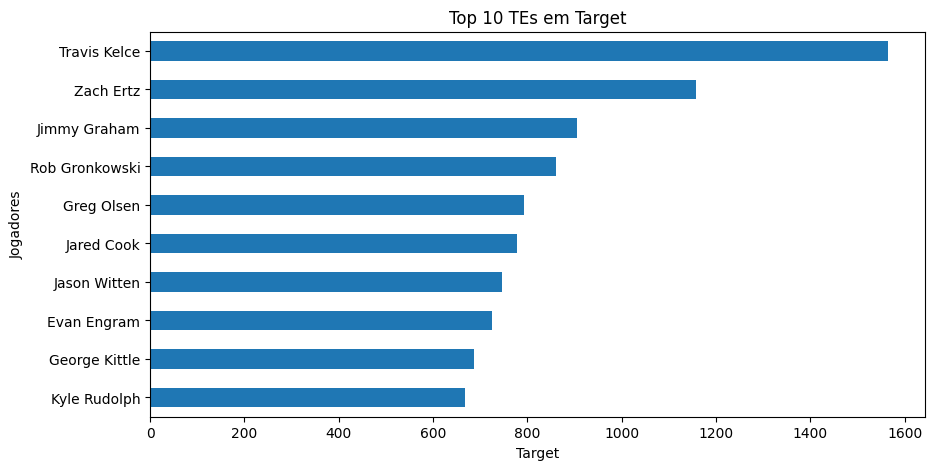

In [210]:
# Top TEs em Target
top_tes_target = tes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

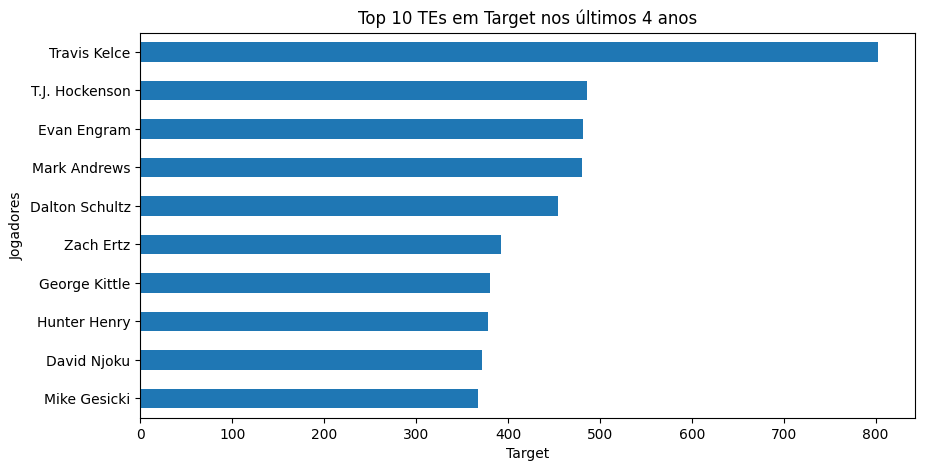

In [213]:
# Top TEs em Target nos últimos 4 anos
top_tes_target_recentes = top_tes_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_tes_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Target nos últimos 4 anos')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

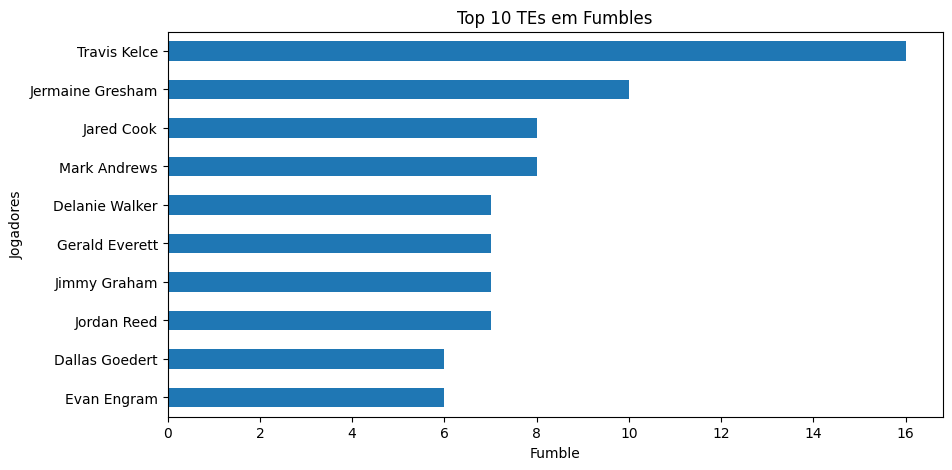

In [214]:
# Top TEs em Fumble
top_tes_fumble = tes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

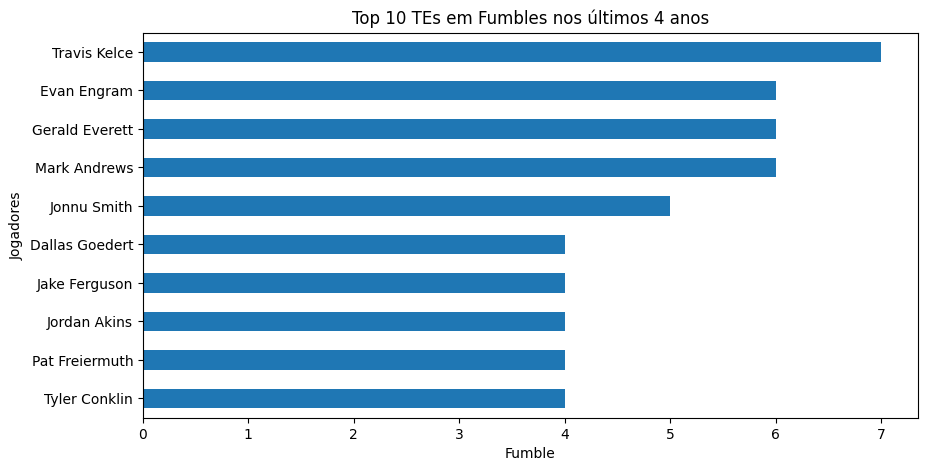

In [215]:
# Top TEs em Fumblee nos últimos 4 anos
top_tes_fumble_recentes = top_tes_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_tes_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 TEs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

####**RB**

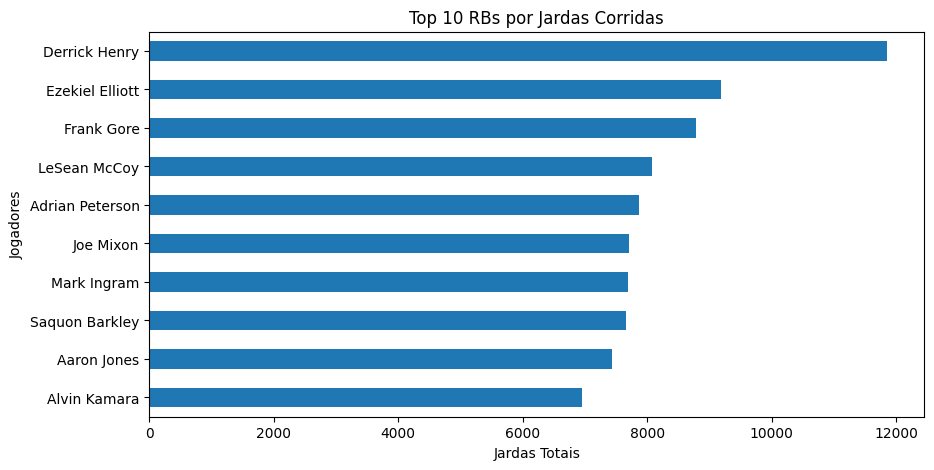

In [216]:
# Top rbs em jardas corridas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Corridas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

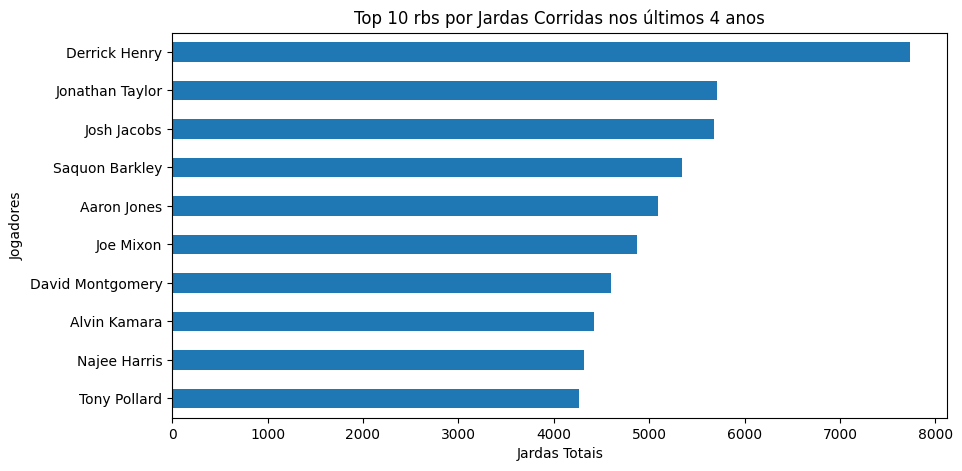

In [217]:
# Top rbs em jardas recebidas nos últimos 4 anos
top_rbs_recenrbs = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recenrbs.groupby('player_name')['rushing_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs por Jardas Corridas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

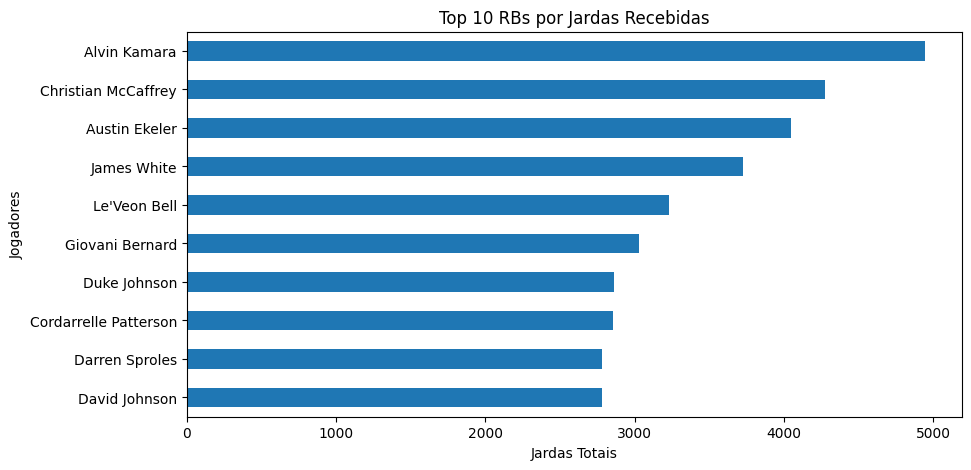

In [218]:
# Top RBs em jardas recebidas
rbs = df_ataque_limpo[df_ataque_limpo['position'] == 'RB']
top_rbs = rbs.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

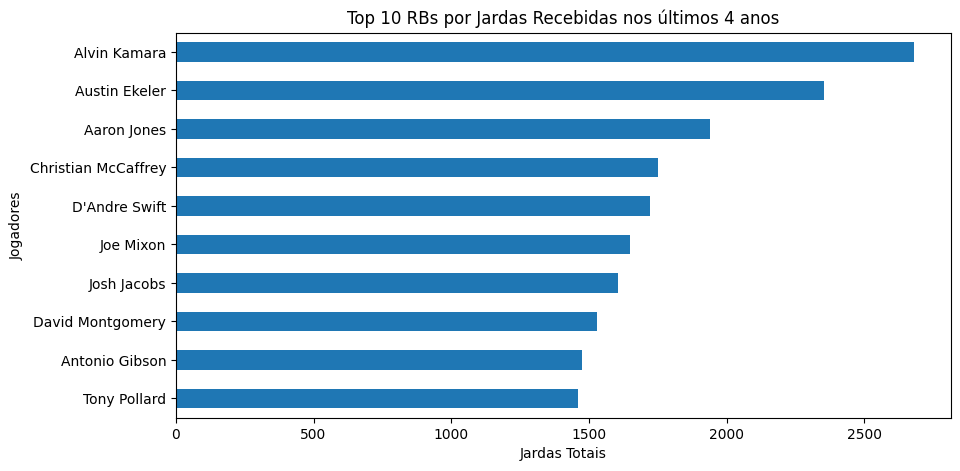

In [219]:
# Top RBs em jardas recebidas nos últimos 4 anos
top_rbs_recentes = df_ataque_limpo[(df_ataque_limpo['position'] == 'RB') & (df_ataque_limpo['season'] >= 2020)]
top_rbs_jardas_recentes = top_rbs_recentes.groupby('player_name')['receiving_yards'].sum().nlargest(10)
top_rbs_jardas_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs por Jardas Recebidas nos últimos 4 anos')
plt.xlabel('Jardas Totais')
plt.ylabel('Jogadores')
plt.show()

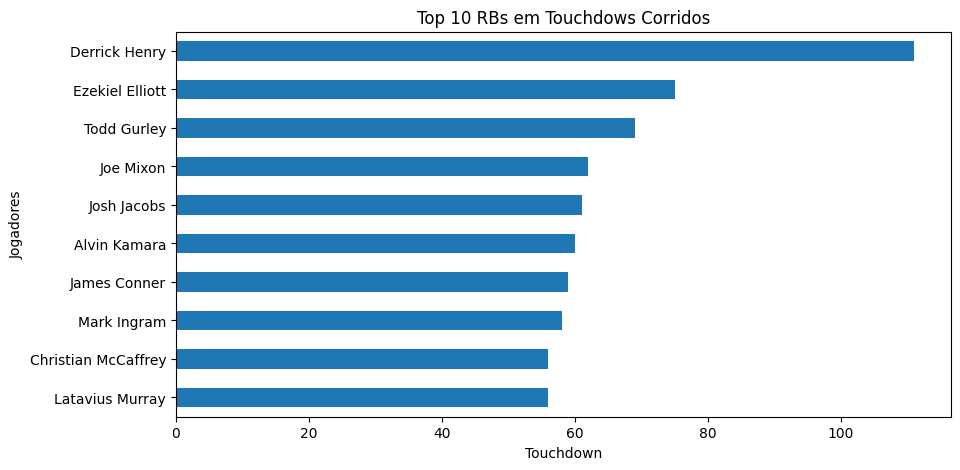

In [220]:
# Top RBs em Tochdowns Corridos
top_rbs_rush_td = rbs.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Corridos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

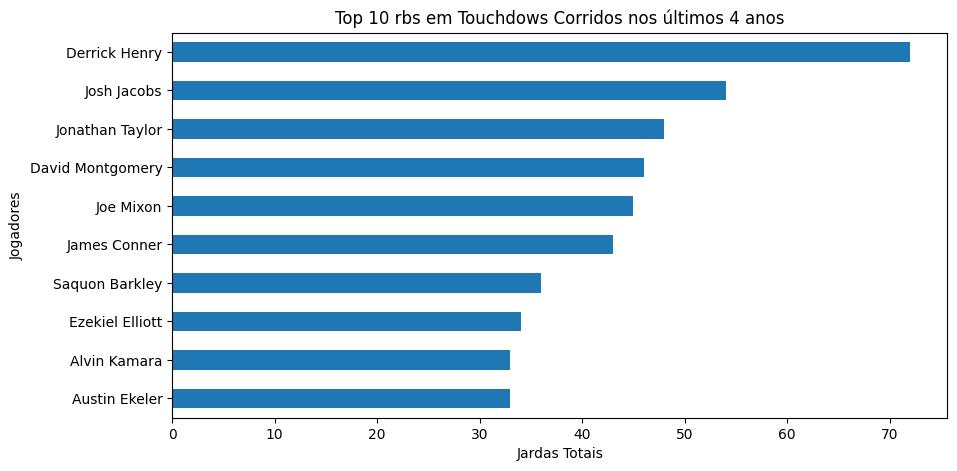

In [221]:
# Top rbs em Touchdown corridos nos últimos 4 anos
top_rbs_rush_td_recentes = top_rbs_recentes.groupby('player_name')['rush_touchdown'].sum().nlargest(10)
top_rbs_rush_td_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 rbs em Touchdows Corridos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

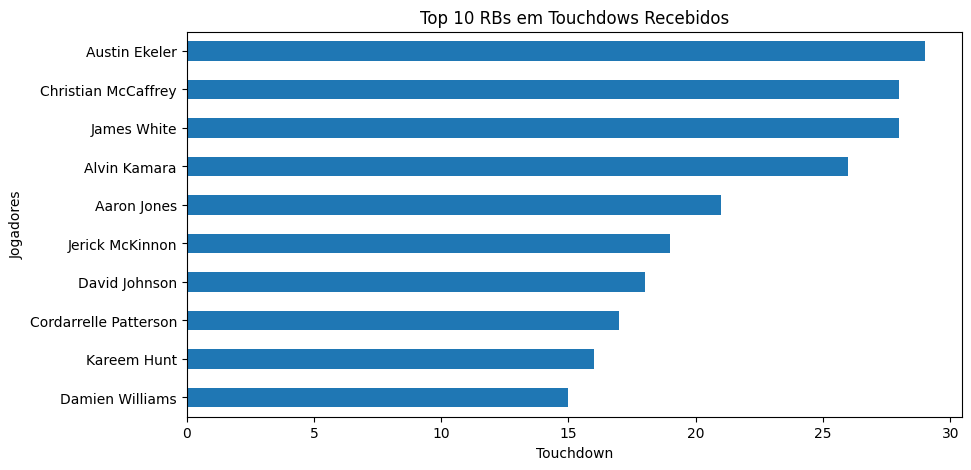

In [223]:
# Top RBs em Tochdowns Recebidos
top_rbs_td_receb = rbs.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows Recebidos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

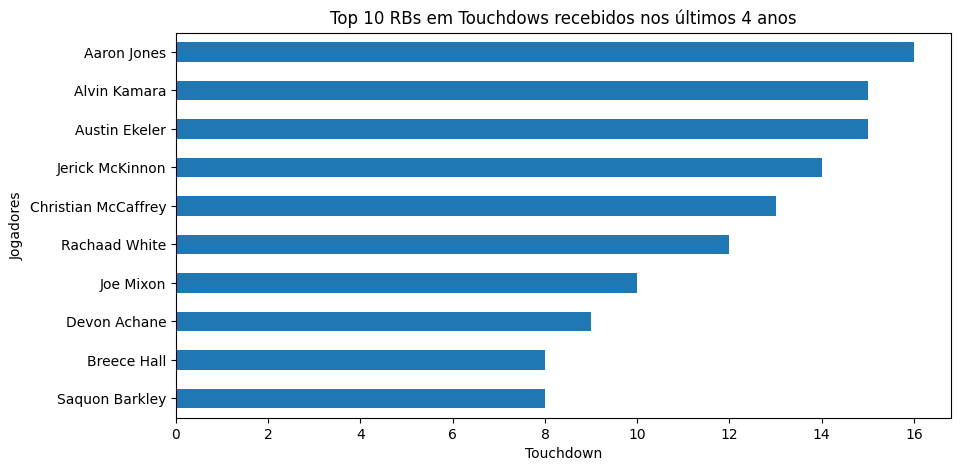

In [225]:
# Top RBs em Tochdowns recebidos nos últimos 4 anos
top_rbs_td_receb_recentes = top_rbs_recentes.groupby('player_name')['receiving_touchdown'].sum().nlargest(10)
top_rbs_td_receb_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Touchdows recebidos nos últimos 4 anos')
plt.xlabel('Touchdown')
plt.ylabel('Jogadores')
plt.show()

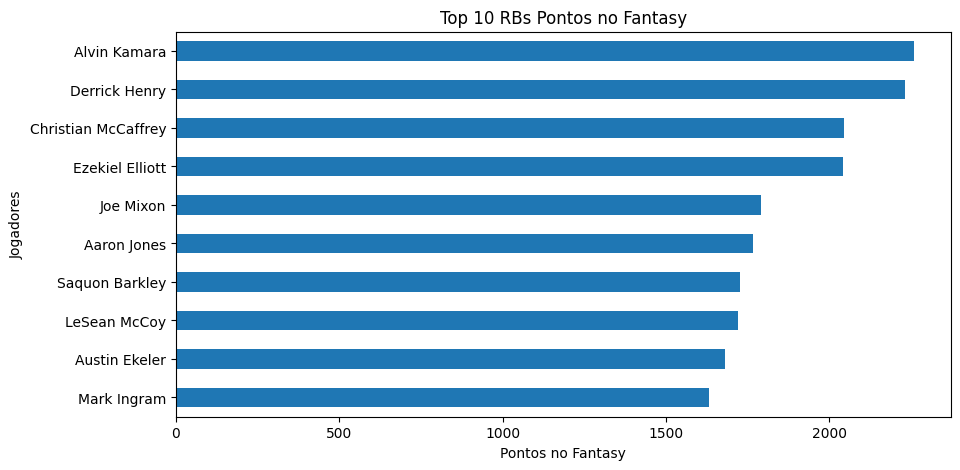

In [227]:
# Top rbs Pontos no Fantasy
top_rbs_fantasy = rbs.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

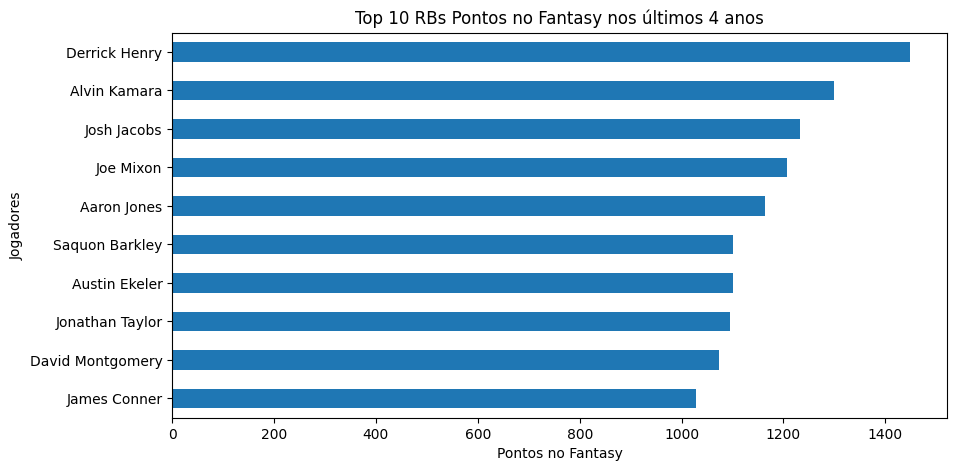

In [228]:
# Top rbs Pontos no Fantasy nos últimos 4 anos
top_rbs_fantasy_recenrb = top_rbs_recentes.groupby('player_name')['fantasy_points_ppr'].sum().nlargest(10)
top_rbs_fantasy_recenrb.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs Pontos no Fantasy nos últimos 4 anos')
plt.xlabel('Pontos no Fantasy')
plt.ylabel('Jogadores')
plt.show()

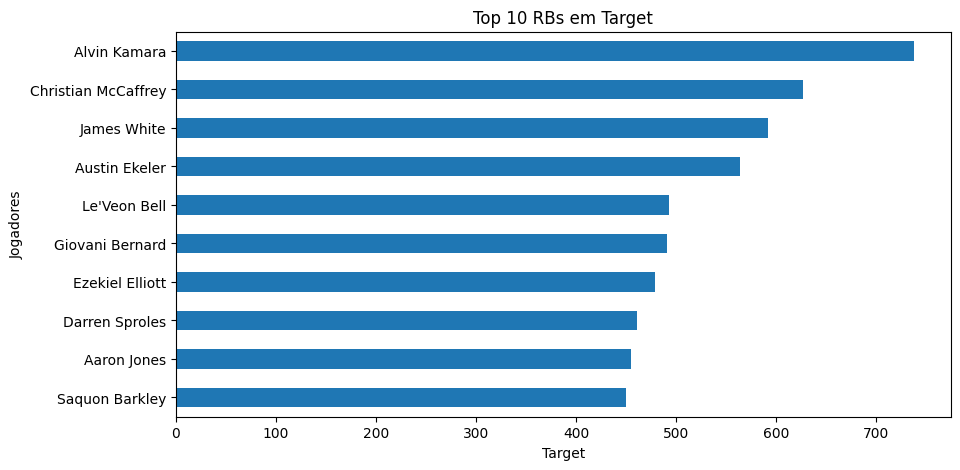

In [229]:
# Top rbs em Target
top_rbs_target = rbs.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

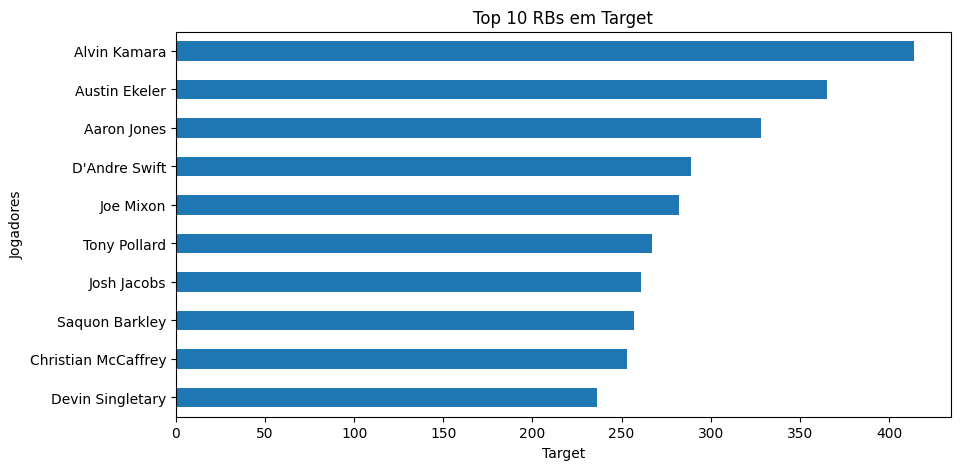

In [230]:
# Top rbs em Target nos últimos 4 anos
top_rbs_target_recentes = top_rbs_recentes.groupby('player_name')['targets'].sum().nlargest(10)
top_rbs_target_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Target')
plt.xlabel('Target')
plt.ylabel('Jogadores')
plt.show()

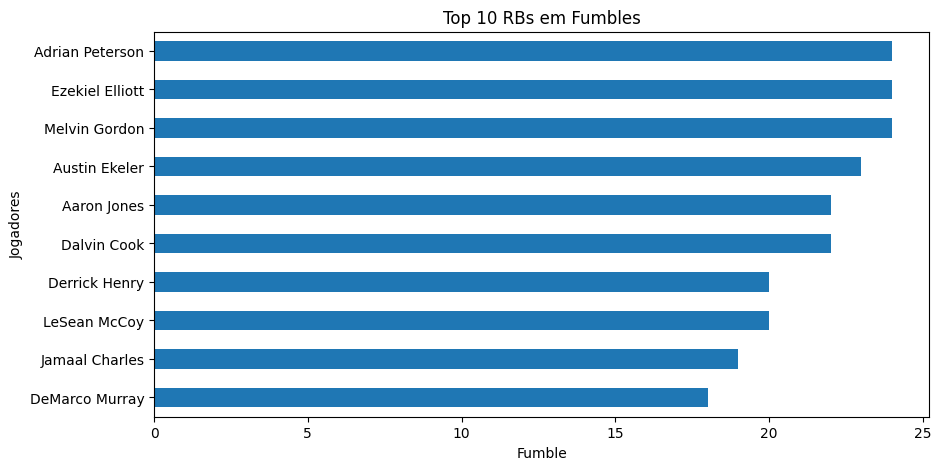

In [231]:
# Top rbs em Fumble
top_rbs_fumble = rbs.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

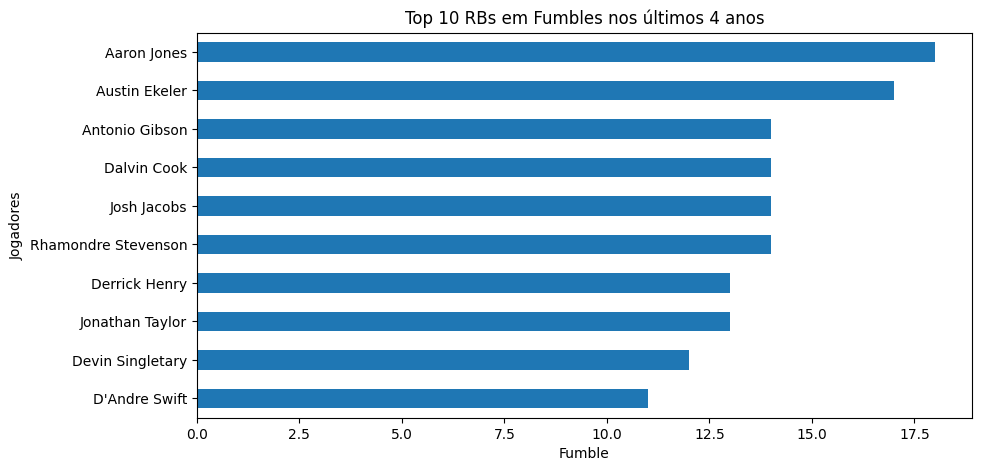

In [232]:
# Top rbs em Fumblee nos últimos 4 anos
top_rbs_fumble_recentes = top_rbs_recentes.groupby('player_name')['fumble'].sum().nlargest(10)
top_rbs_fumble_recentes.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 RBs em Fumbles nos últimos 4 anos')
plt.xlabel('Fumble')
plt.ylabel('Jogadores')
plt.show()

TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 1364
Total TDs na última temporada: 1592
Variação percentual entre primeira e última: 16.7%


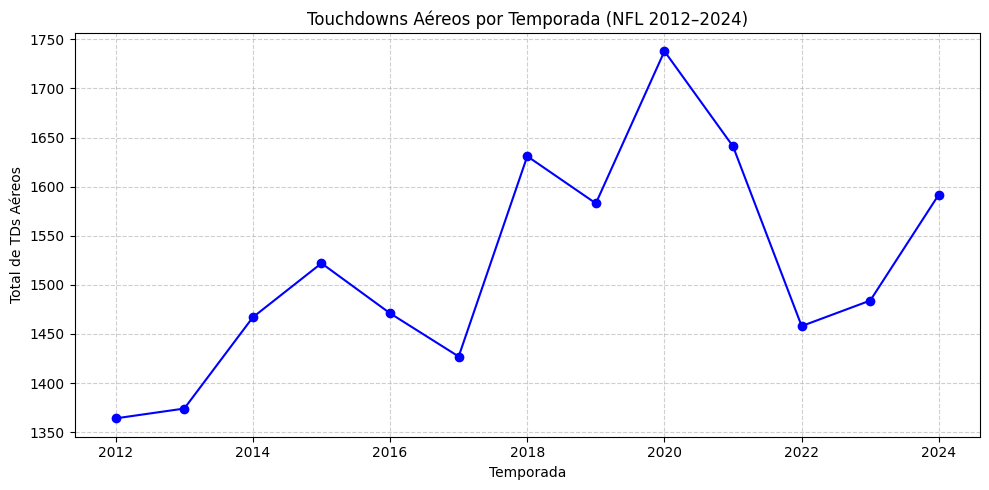

In [156]:
# Agrupando touchdowns de passe por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['pass_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['pass_touchdown'].iloc[0], td_por_temporada['pass_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['pass_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Aéreos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Aéreos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



TDs aéreos: 2012 → 2024
Total TDs na primeira temporada: 347
Total TDs na última temporada: 524
Variação percentual entre primeira e última: 51.0%


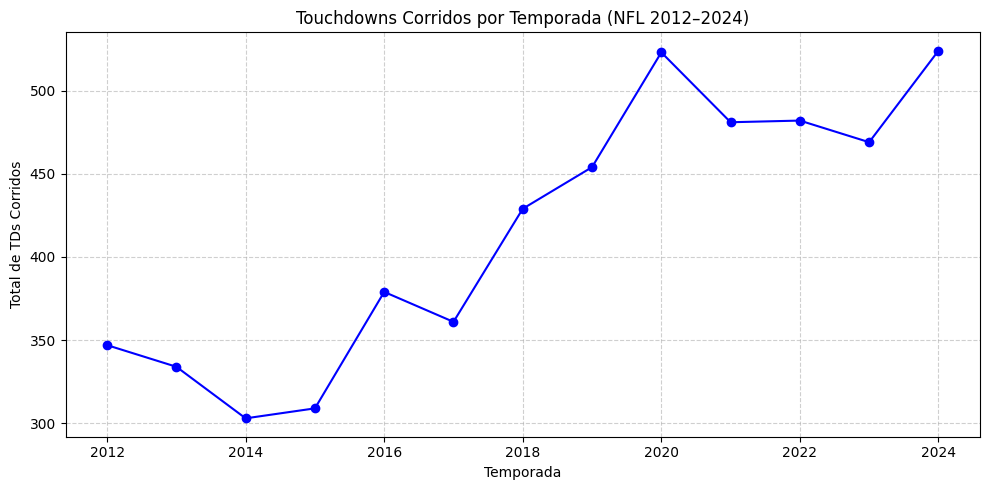

In [157]:
# Agrupando touchdowns de corrida por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_touchdown'].iloc[0], td_por_temporada['rush_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs aéreos: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_touchdown'], marker='o', color='blue')
plt.title('Touchdowns Corridos por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs Corridos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

TDs totais: 2012 → 2024
Total TDs na primeira temporada: 1711
Total TDs na última temporada: 2116
Variação percentual entre primeira e última: 23.7%


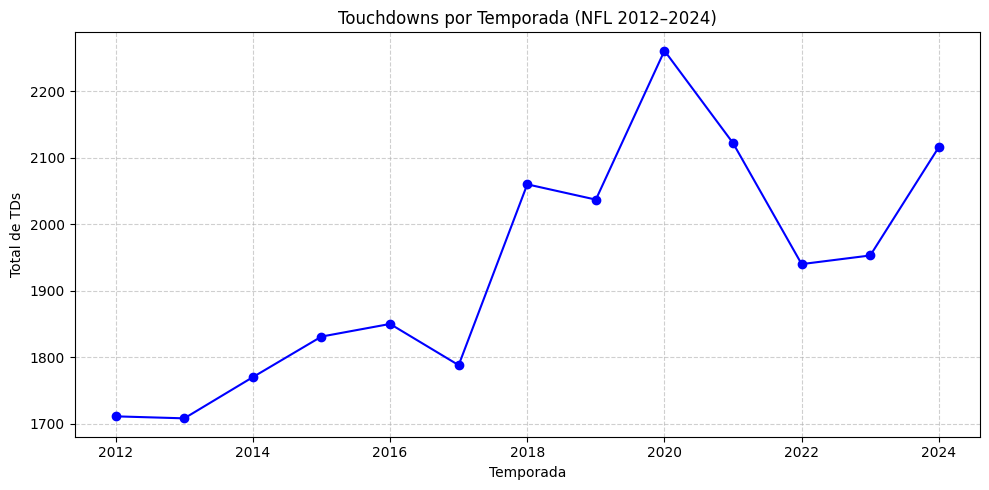

In [158]:
# Agrupando touchdowns por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['total_touchdown']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['total_touchdown'].iloc[0], td_por_temporada['total_touchdown'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"TDs totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total TDs na primeira temporada: {primeira:.0f}")
print(f"Total TDs na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['total_touchdown'], marker='o', color='blue')
plt.title('Touchdowns por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Total de TDs')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Passes completados totais: 2012 → 2024
Total de passes completados na primeira temporada: 10286
Total de passes completados na última temporada: 11807
Variação percentual entre primeira e última: 14.8%


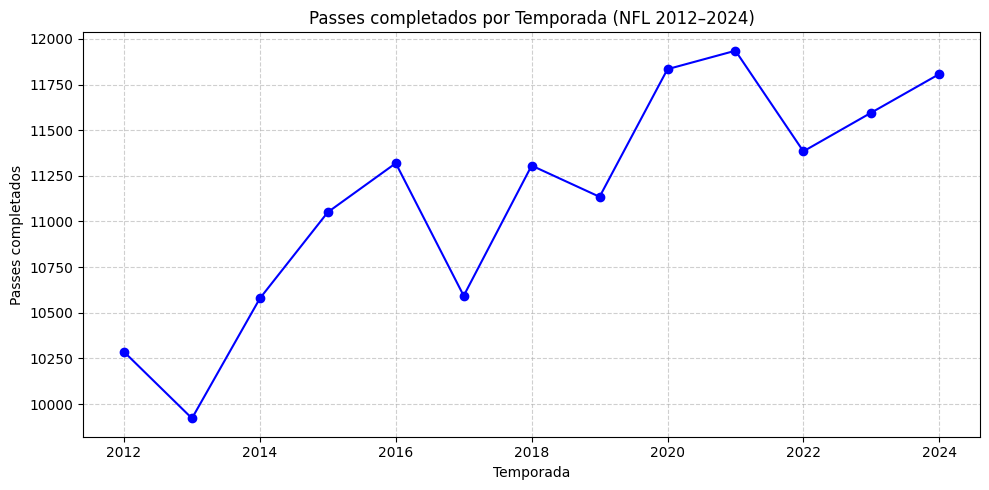

In [159]:
# Agrupando por passes completados por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['complete_pass']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['complete_pass'].iloc[0], td_por_temporada['complete_pass'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Passes completados totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de passes completados na primeira temporada: {primeira:.0f}")
print(f"Total de passes completados na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['complete_pass'], marker='o', color='blue')
plt.title('Passes completados por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Passes completados')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tentativa de corrida totais: 2012 → 2024
Total de tentativa de corridas na primeira temporada: 11747
Total de tentativa de corridas na última temporada: 14266
Variação percentual entre primeira e última: 21.4%


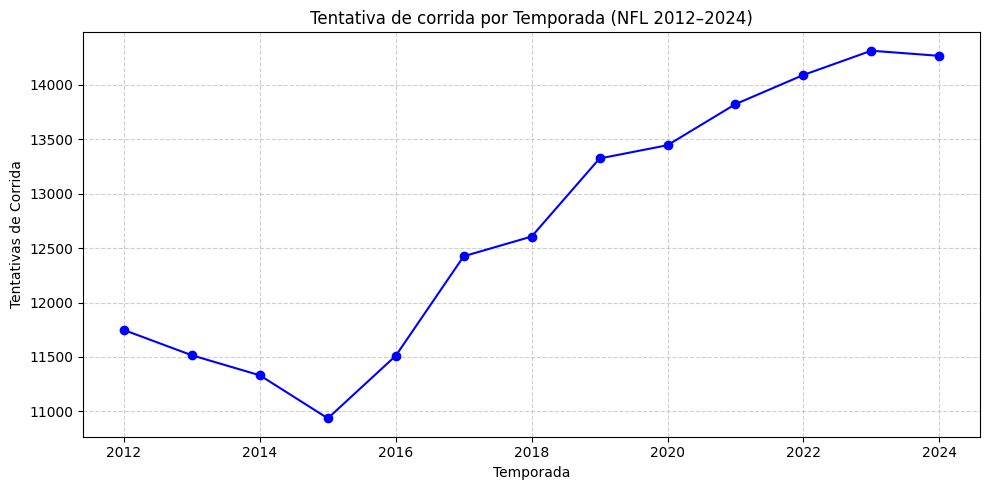

In [160]:
# Agrupando por tentativas de corridas por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['rush_attempts']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['rush_attempts'].iloc[0], td_por_temporada['rush_attempts'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Tentativa de corrida totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de tentativa de corridas na primeira temporada: {primeira:.0f}")
print(f"Total de tentativa de corridas na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['rush_attempts'], marker='o', color='blue')
plt.title('Tentativa de corrida por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Tentativas de Corrida')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por carregada totais: 2012 → 2024
Total de Jardas por carregada na primeira temporada: 1042
Total de Jardas por carregada na última temporada: 1331
Variação percentual entre primeira e última: 27.6%


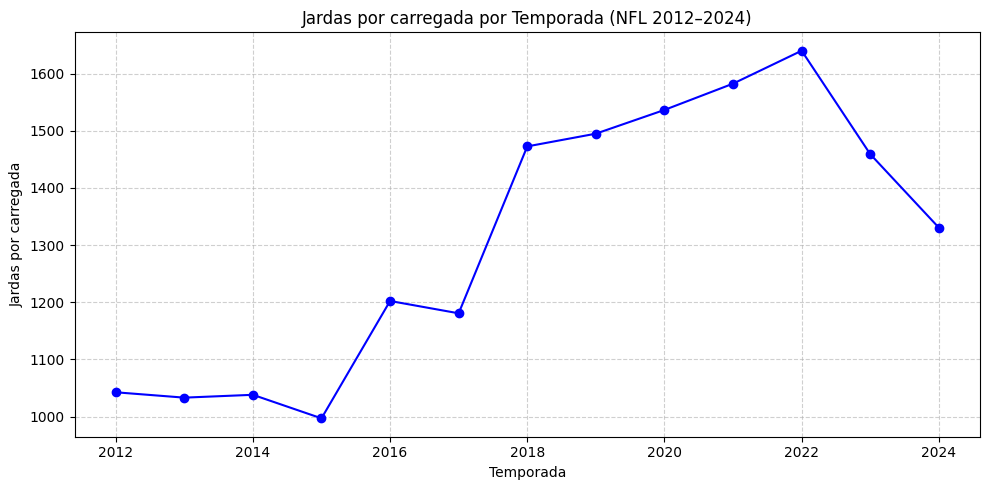

In [161]:
# Agrupando por jardas por carregada por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_carry']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_carry'].iloc[0], td_por_temporada['yards_per_carry'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por carregada totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por carregada na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por carregada na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_carry'], marker='o', color='blue')
plt.title('Jardas por carregada por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por carregada')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Jardas por recepção totais: 2012 → 2024
Total de Jardas por recepção na primeira temporada: 3610
Total de Jardas por recepção na última temporada: 4677
Variação percentual entre primeira e última: 29.6%


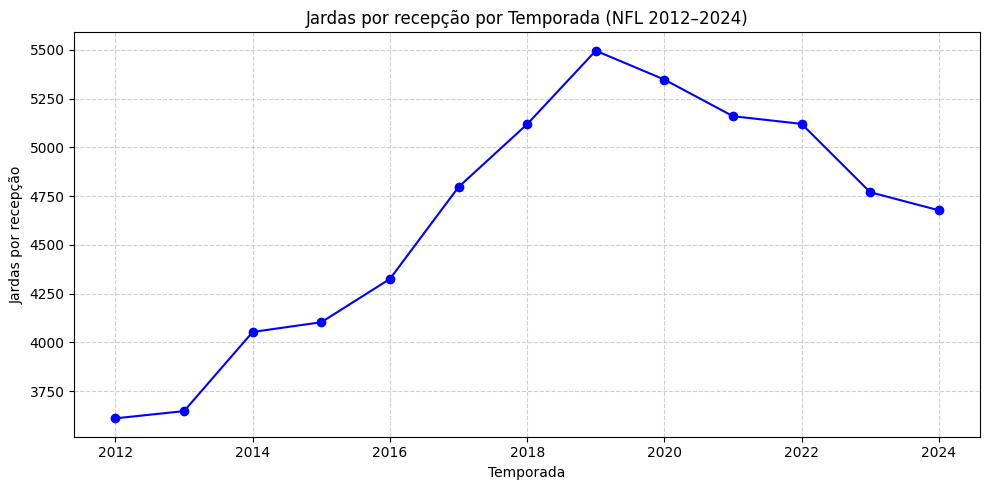

In [162]:
# Agrupando por jardas por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['yards_per_reception']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['yards_per_reception'].iloc[0], td_por_temporada['yards_per_reception'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Jardas por recepção totais: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de Jardas por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de Jardas por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['yards_per_reception'], marker='o', color='blue')
plt.title('Jardas por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Jardas por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Taxa de recepção: 2012 → 2024
Total de taxa por recepção na primeira temporada: 224
Total de taxa por recepção na última temporada: 331
Variação percentual entre primeira e última: 48.0%


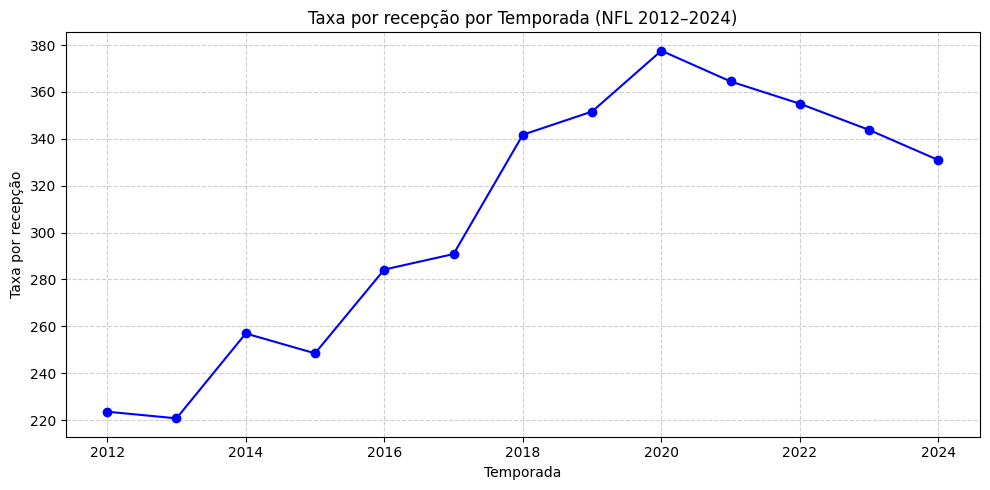

In [163]:
# Agrupando por taxa por recepção por temporada
td_por_temporada = (
    df_ataque_limpo
    .groupby('season')['catch_rate']
    .sum()
    .reset_index()
    .sort_values('season')
)

# Estatísticas rápidas
primeira, ultima = td_por_temporada['catch_rate'].iloc[0], td_por_temporada['catch_rate'].iloc[-1]
pct_change = (ultima - primeira) / primeira * 100 if primeira != 0 else np.nan
print(f"Taxa de recepção: {td_por_temporada['season'].min()} → {td_por_temporada['season'].max()}")
print(f"Total de taxa por recepção na primeira temporada: {primeira:.0f}")
print(f"Total de taxa por recepção na última temporada: {ultima:.0f}")
print(f"Variação percentual entre primeira e última: {pct_change:.1f}%")

# Cria o gráfico simples
plt.figure(figsize=(10,5))
plt.plot(td_por_temporada['season'], td_por_temporada['catch_rate'], marker='o', color='blue')
plt.title('Taxa por recepção por Temporada (NFL 2012–2024)')
plt.xlabel('Temporada')
plt.ylabel('Taxa por recepção')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###**Defesa**

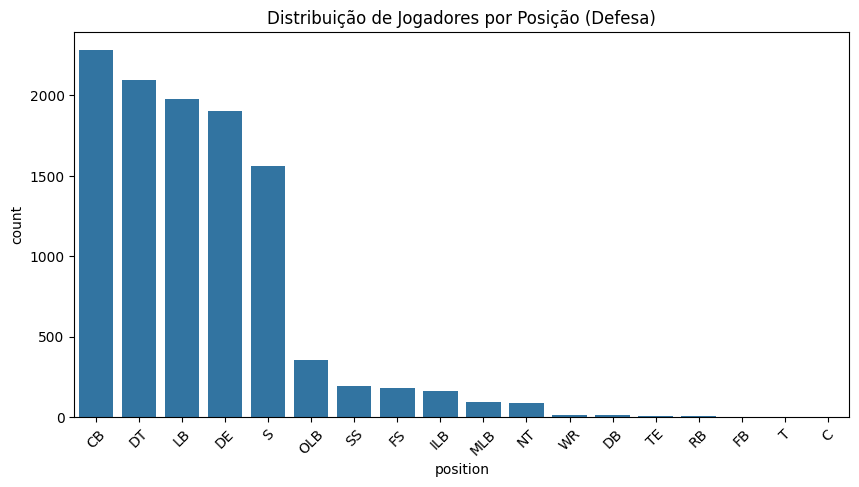

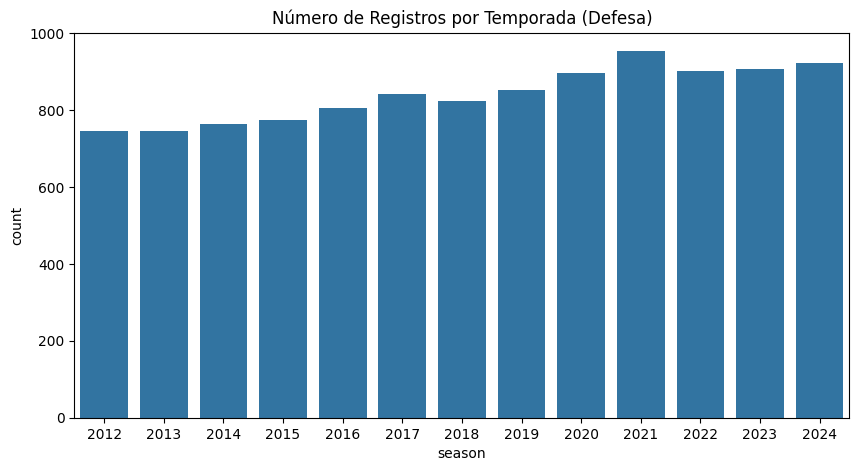

In [164]:
# Gráfico para verificar a distribuição dos jogadores por posição
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='position', order=df_defesa_limpo['position'].value_counts().index)
plt.title('Distribuição de Jogadores por Posição (Defesa)')
plt.xticks(rotation=45)
plt.show()

# Número de registros por temporada
plt.figure(figsize=(10,5))
sns.countplot(data=df_defesa_limpo, x='season')
plt.title('Número de Registros por Temporada (Defesa)')
plt.show()

In [165]:
# Estatísticas da defesa
df_defesa_limpo.describe()[['tackles_total', 'sack', 'qb_hit', 'interception', 'fumble_forced', 'def_touchdown']]

,tackles_total,sack,qb_hit,interception,fumble_forced,def_touchdown
count,10939.000000,10939.000000,10939.000000,10939.000000,10939.000000,10939.000000
mean,42.291251,5.756742,8.497669,1.126794,1.401225,0.161075
std,37.987574,10.372226,12.726330,2.165175,2.703147,0.620856
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,64.000000,7.000000,10.000000,2.000000,2.000000,0.000000
max,231.000000,92.000000,112.000000,22.000000,33.000000,10.000000


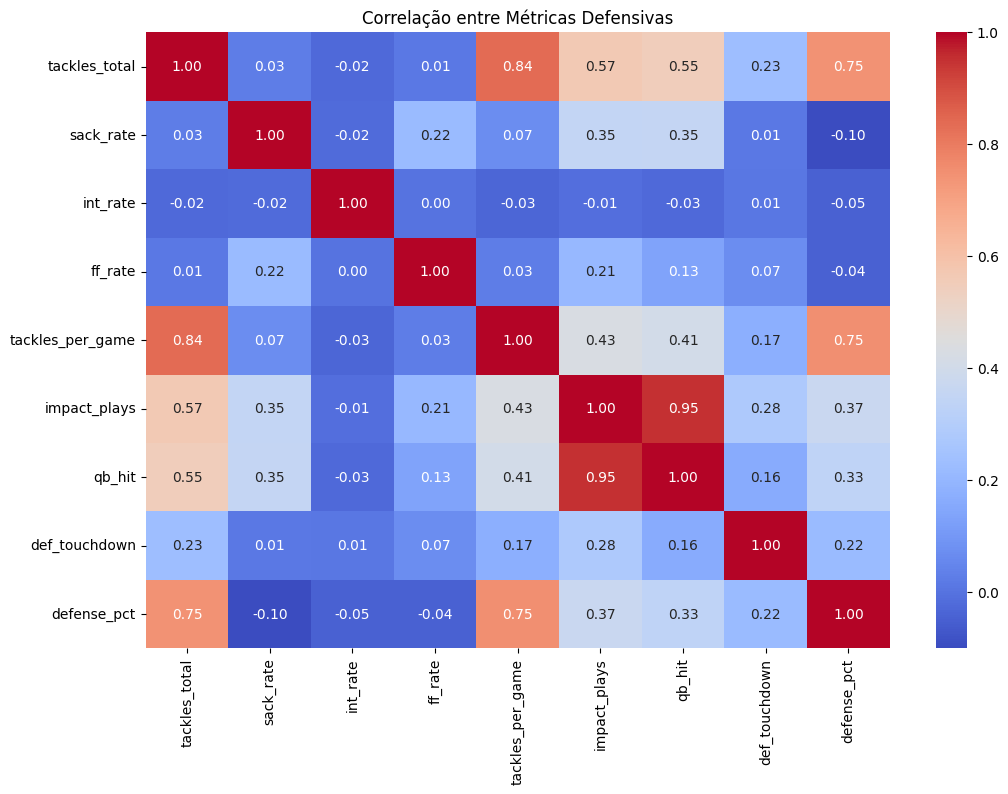

In [166]:
# Correlação entre variáveis
corr_cols = ['tackles_total', 'sack_rate', 'int_rate', 'ff_rate', 'tackles_per_game', 'impact_plays',
             'qb_hit',  'def_touchdown', 'defense_pct']
plt.figure(figsize=(12, 8))
sns.heatmap(df_defesa_limpo[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Métricas Defensivas')
plt.show()

####**CB**

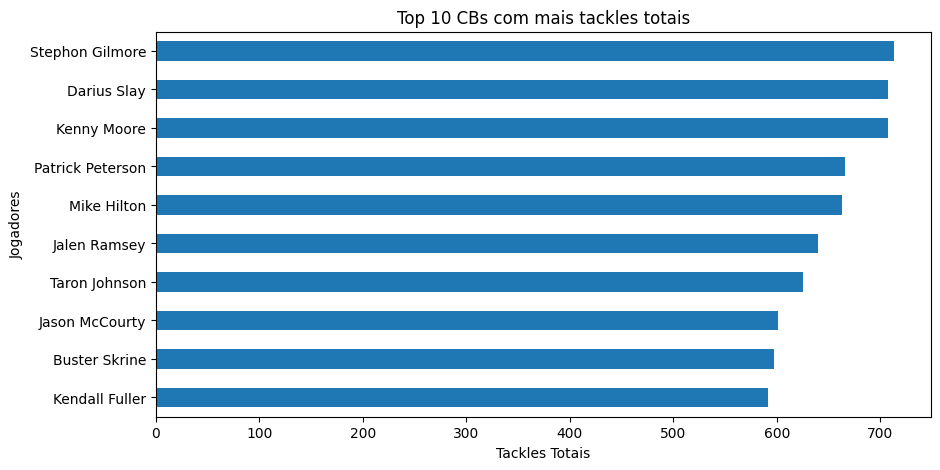

In [233]:
# Top CBs com mais tackles totais
cbs = df_defesa_limpo[df_defesa_limpo['position'] == 'CB']
top_cbs_tackles = cbs.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais tackles totais')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

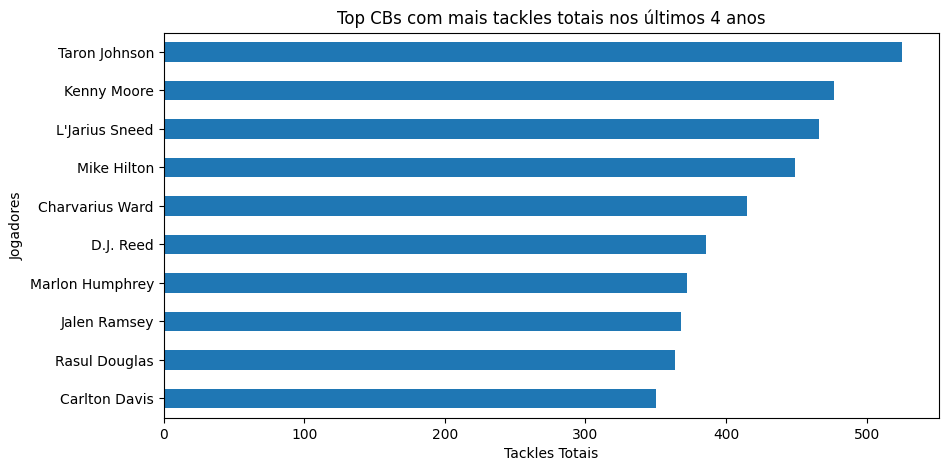

In [234]:
# Top CBs com mais tackles totais nos últimos 4 anos
cbs_recentes = df_defesa_limpo[(df_defesa_limpo['position'] == 'CB') & (df_defesa_limpo['season'] >= 2020)]
top_cbs_tackles_recente = cbs_recentes.groupby('player_name')['tackles_total'].sum().nlargest(10)
top_cbs_tackles_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais tackles totais nos últimos 4 anos')
plt.xlabel('Tackles Totais')
plt.ylabel('Jogadores')
plt.show()

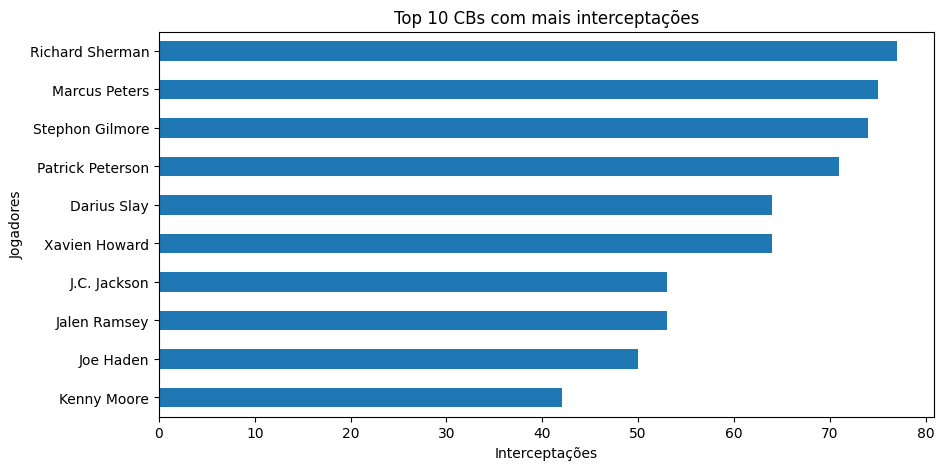

In [235]:
# Top CBs com mais interceptações
top_cbs_int = cbs.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com mais interceptações')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

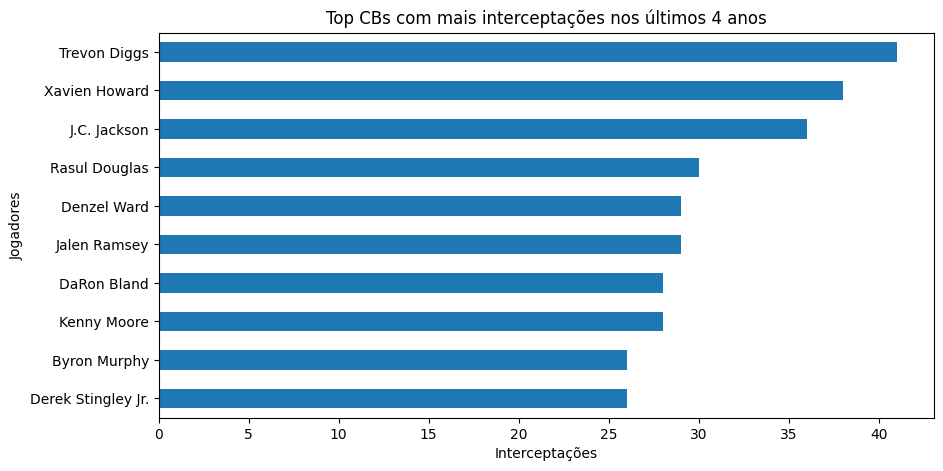

In [236]:
# Top CBs com mais interceptações nos últimos 4 anos
top_cbs_int_recente = cbs_recentes.groupby('player_name')['interception'].sum().nlargest(10)
top_cbs_int_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top CBs com mais interceptações nos últimos 4 anos')
plt.xlabel('Interceptações')
plt.ylabel('Jogadores')
plt.show()

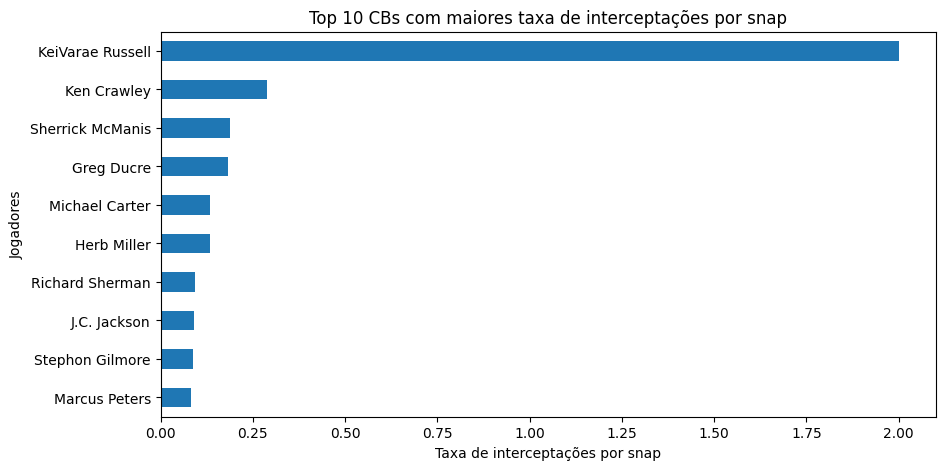

In [237]:
# Top CBs com mais taxa de interceptações por snap
top_cbs_int_rate = cbs.groupby('player_name')['int_rate'].sum().nlargest(10)
top_cbs_int_rate.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com maiores taxa de interceptações por snap')
plt.xlabel('Taxa de interceptações por snap')
plt.ylabel('Jogadores')
plt.show()

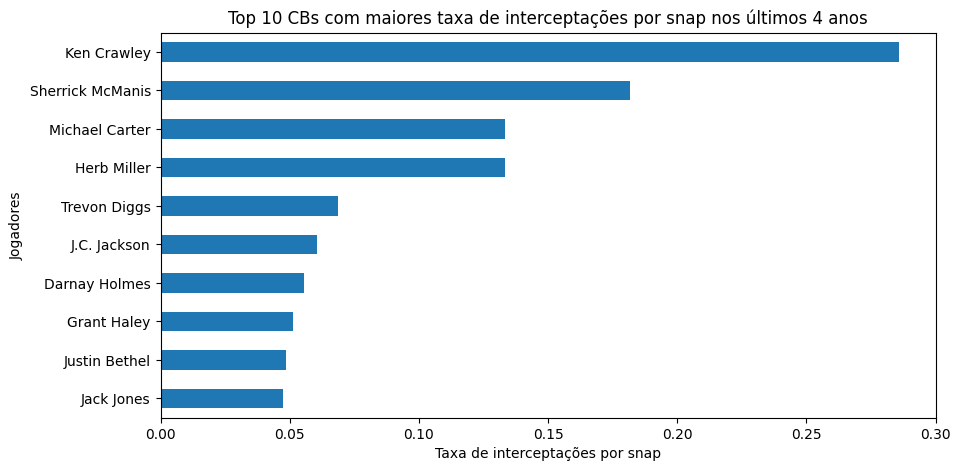

In [238]:
# Top CBs com mais taxa de interceptações por snap nos últimos 4 anos
top_cbs_int_rate_recente = cbs_recentes.groupby('player_name')['int_rate'].sum().nlargest(10)
top_cbs_int_rate_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com maiores taxa de interceptações por snap nos últimos 4 anos')
plt.xlabel('Taxa de interceptações por snap')
plt.ylabel('Jogadores')
plt.show()

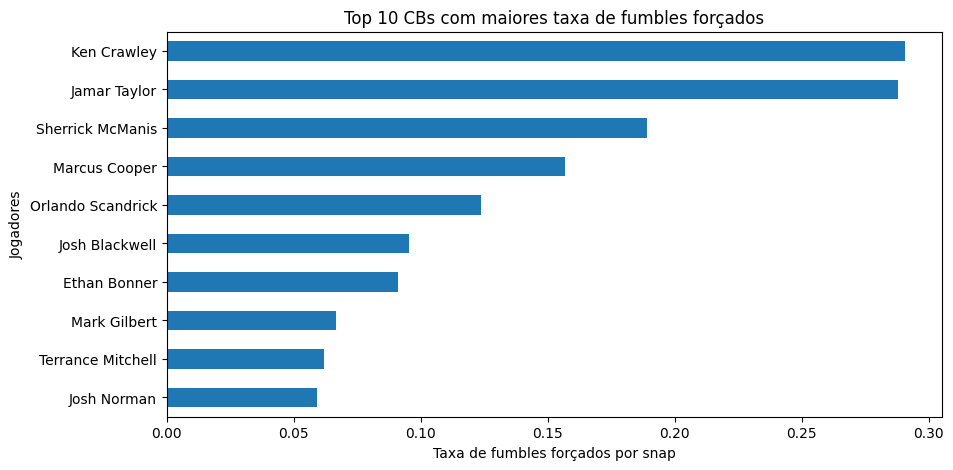

In [239]:
# Top CBs com mais taxa de interceptações por snap
top_cbs_ff_rate = cbs.groupby('player_name')['ff_rate'].sum().nlargest(10)
top_cbs_ff_rate.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com maiores taxa de fumbles forçados')
plt.xlabel('Taxa de fumbles forçados por snap')
plt.ylabel('Jogadores')
plt.show()

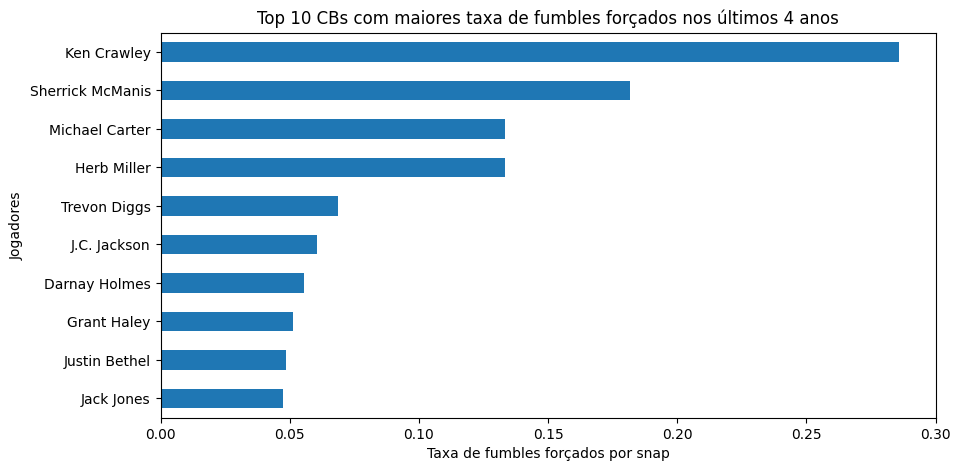

In [240]:
# Top CBs com mais taxa de interceptações por snap nos últimos 4 anos
top_cbs_ff_rate_recente = cbs_recentes.groupby('player_name')['int_rate'].sum().nlargest(10)
top_cbs_ff_rate_recente.iloc[::-1].plot(kind='barh', figsize=(10,5), title='Top 10 CBs com maiores taxa de fumbles forçados nos últimos 4 anos')
plt.xlabel('Taxa de fumbles forçados por snap')
plt.ylabel('Jogadores')
plt.show()

####**FS e SS**

In [175]:
df_defesa_limpo.columns

Index(['player_id', 'player_name', 'position', 'team', 'season', 'age',
       'games_played_season', 'height', 'weight', 'college', 'draft_year',
       'draft_round', 'draft_pick', 'seasons_played', 'solo_tackle',
       'assist_tackle', 'tackle_with_assist', 'sack', 'qb_hit', 'interception',
       'fumble_forced', 'safety', 'def_touchdown', 'defense_snaps',
       'defense_pct', 'fantasy_points_ppr', 'fantasy_points_standard',
       'tackles_total', 'sack_rate', 'int_rate', 'ff_rate', 'tackles_per_game',
       'impact_plays'],
      dtype='object')